In [19]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
from matplotlib.dates import MonthLocator, DateFormatter

In [20]:




citiesL = ["Durban", "Richards Bay", "Cape Town", "Dar Es Salaam", 
           "Mombasa", "Maputo", "Beira", "Walvis Bay", "Douala", 
           "Tangier-Mediterranean", "Jorf Lasfar", "Alexandria", 
           "Port Said", "Lagos-Apapa-Tin Can Island", "Bonny", "Tema", 
           "Abidjan", "San Pedro", "Bissau", "Mogadishu", "Berbera", 
           "Djibouti", "Ningbo"]

city_to_pair = {
    # South Africa
    "Durban": "ZARUSD=X",
    "Richards Bay": "ZARUSD=X",
    "Cape Town": "ZARUSD=X",

    # Tanzania
    "Dar Es Salaam": "TZSUSD=X",

    # Kenya
    "Mombasa": "KESUSD=X",

    # Mozambique
    "Maputo": "MZNUSD=X",
    "Beira": "MZNUSD=X",

    # Namibia
    "Walvis Bay": "NADUSD=X",

    # Cameroon
    "Douala": "XAFUSD=X",       

    # Morocco
    "Tangier-Mediterranean": "MADUSD=X",
    "Jorf Lasfar": "MADUSD=X",

    # Egypt
    "Alexandria": "EGPUSD=X",
    "Port Said": "EGPUSD=X",

    # Nigeria
    "Lagos-Apapa-Tin Can Island": "NGNUSD=X",
    "Bonny": "NGNUSD=X",

    # Ghana
    "Tema": "GHSUSD=X",

    # Côte d’Ivoire
    "Abidjan": "XOFUSD=X",    

    # Côte d’Ivoire (San Pedro)
    "San Pedro": "XOFUSD=X",

    # Guinea-Bissau 
    "Bissau": "XOFUSD=X",

    # Somalia
    "Mogadishu": "SOSUSD=X",

    # Somaliland (Berbera) — may not be valid since this port uses somaliland shilling
    "Berbera": "SOSUSD=X",

    # Djibouti
    "Djibouti": "DJFUSD=X",


    # China
    "Ningbo": "CNYUSD=X",
}
cities = {}


durban = portData[portData.get('portname')=='Durban']
#durban.plot(kind='line', x='Date', y=')

#Take a look at any shocks of Nigerian ports around key oil changes 
# Dangote - 2023-2024 and check if anything vaused that
# Correlation between distance of two ports (Does distance play a role)

In [28]:
portData = pd.read_csv('portactivity.csv')
for c in citiesL:
    cities[c] = [portData[portData.get('portname')==c], city_to_pair[c]]

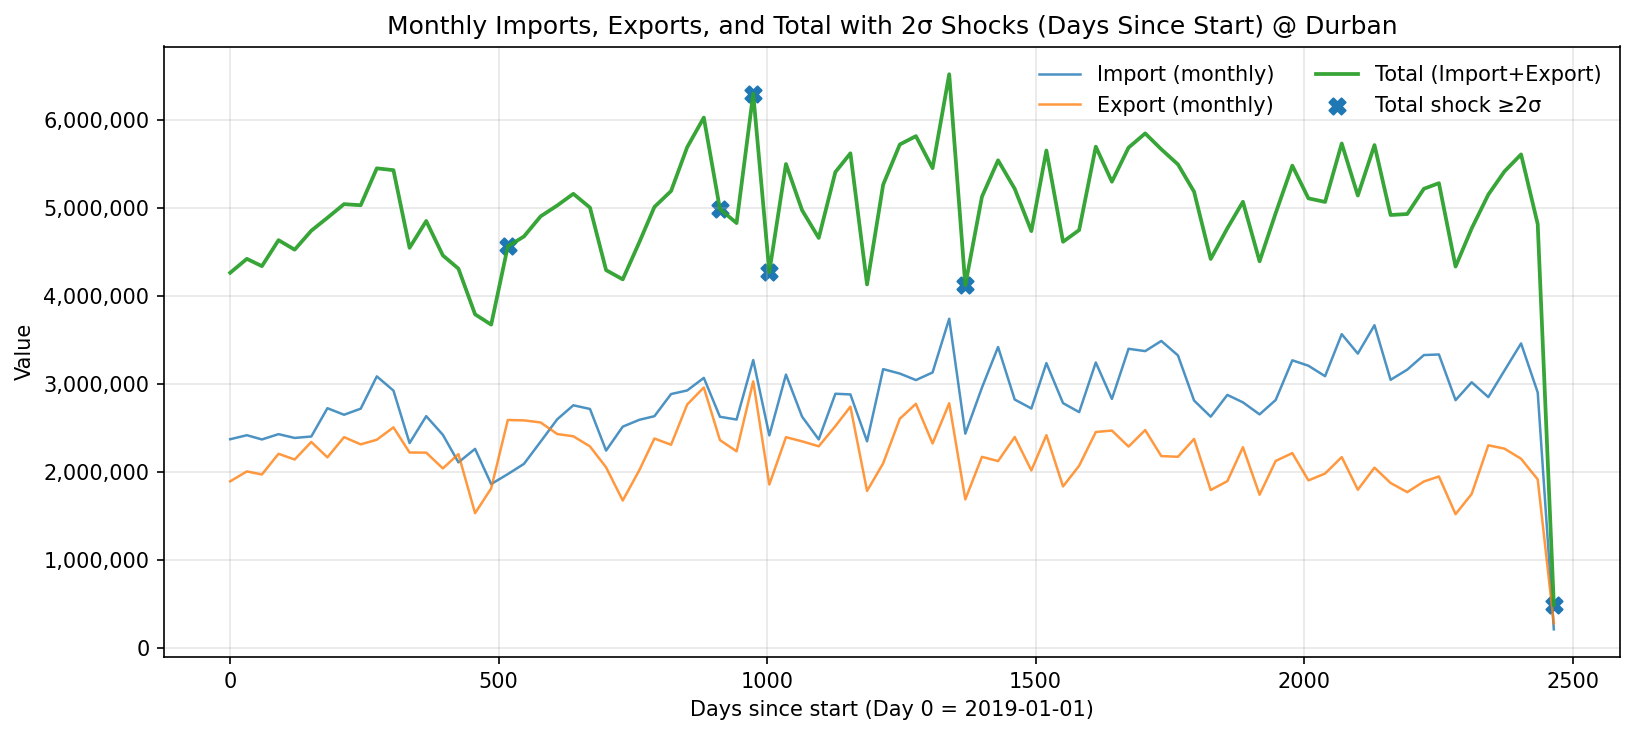

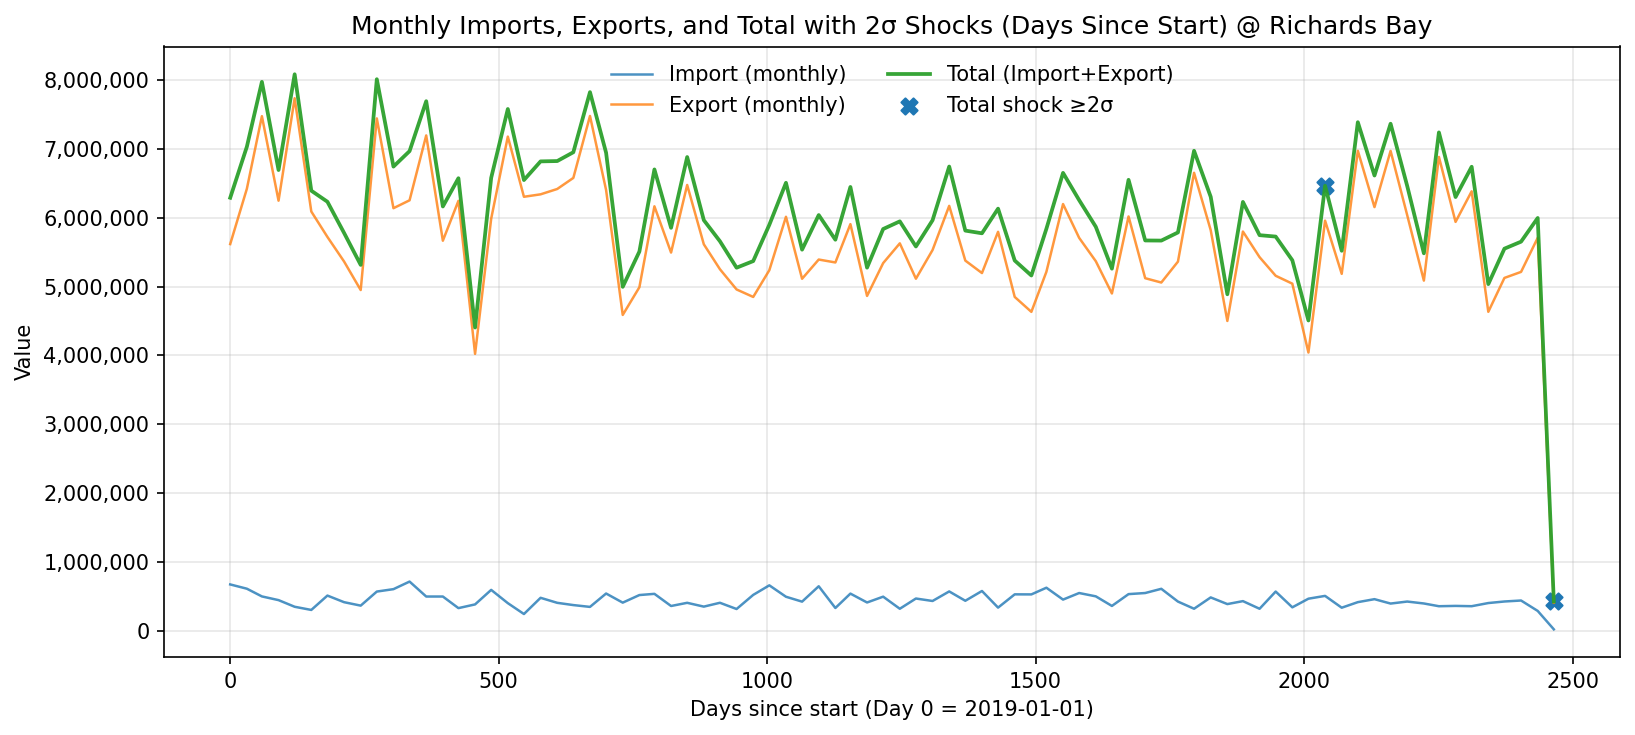

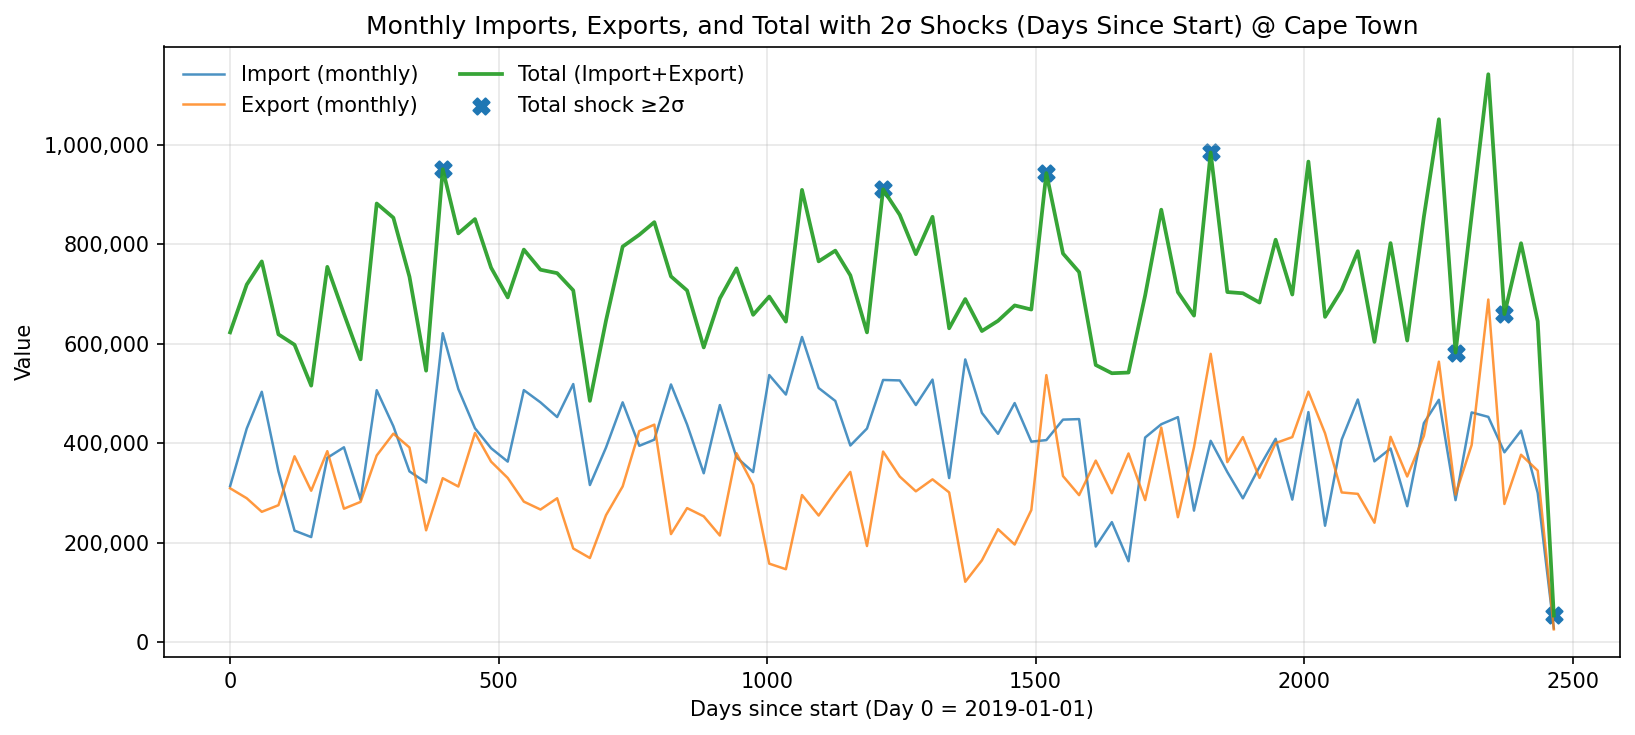

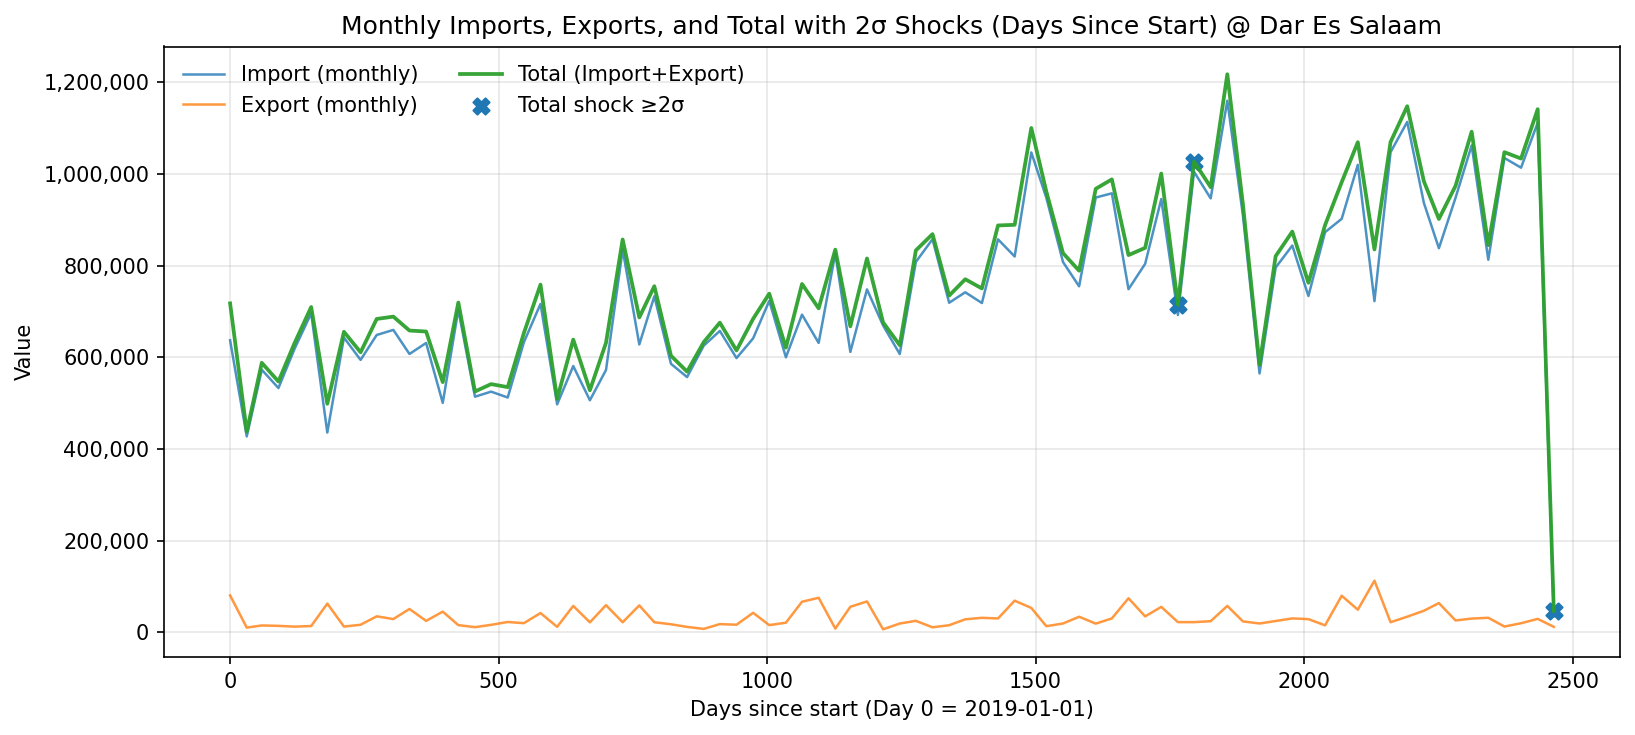

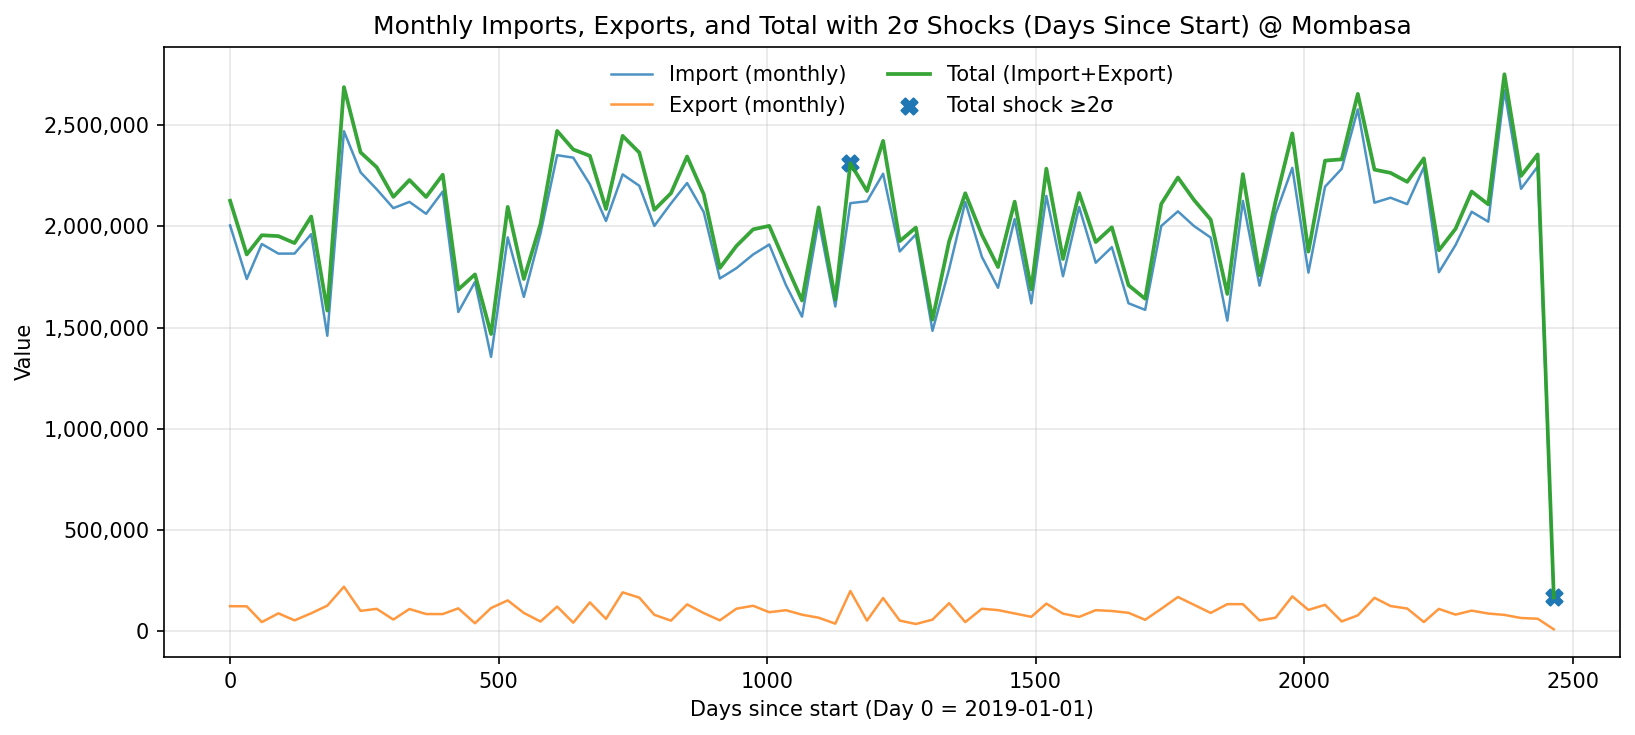

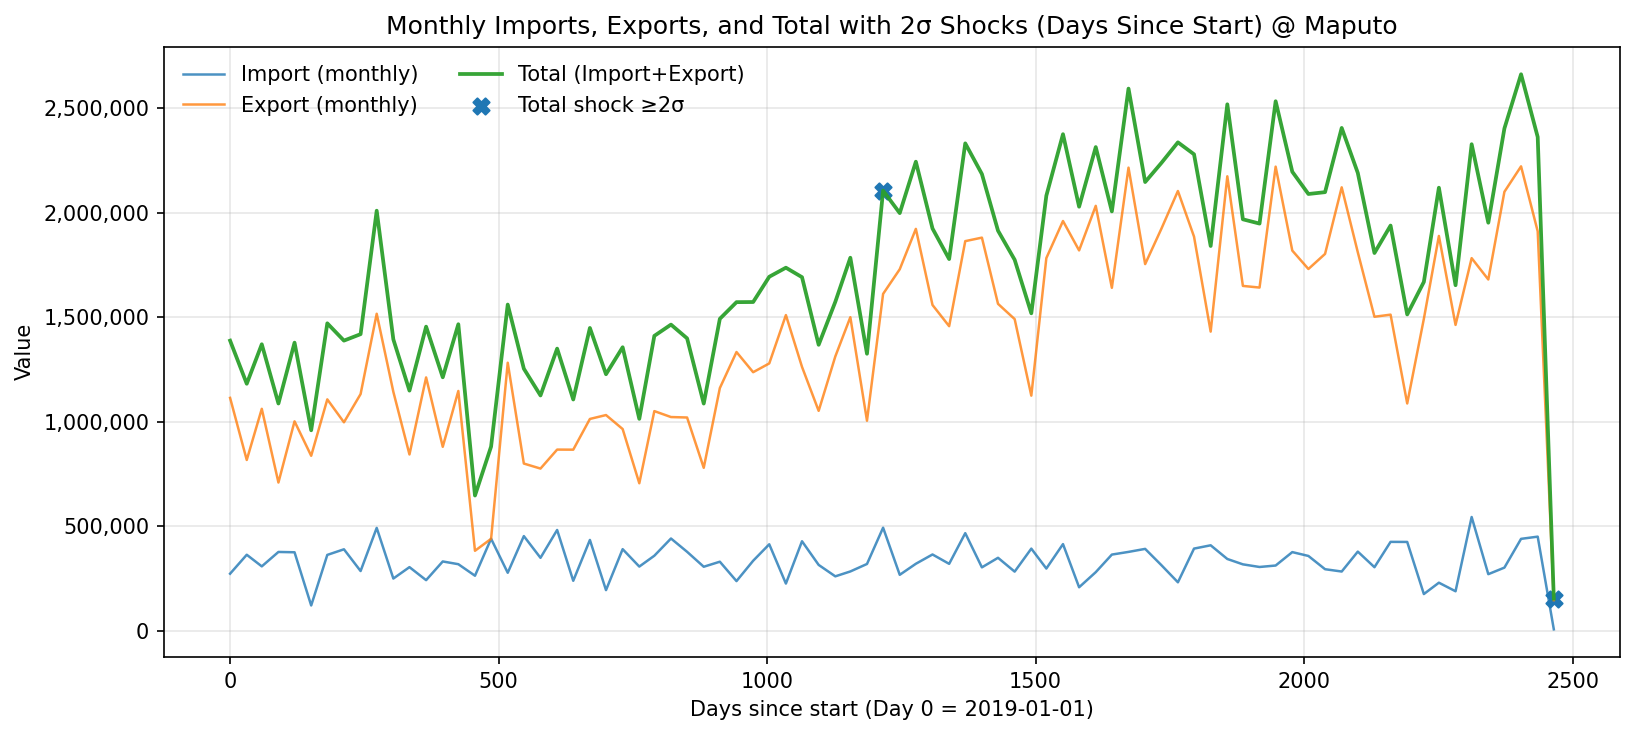

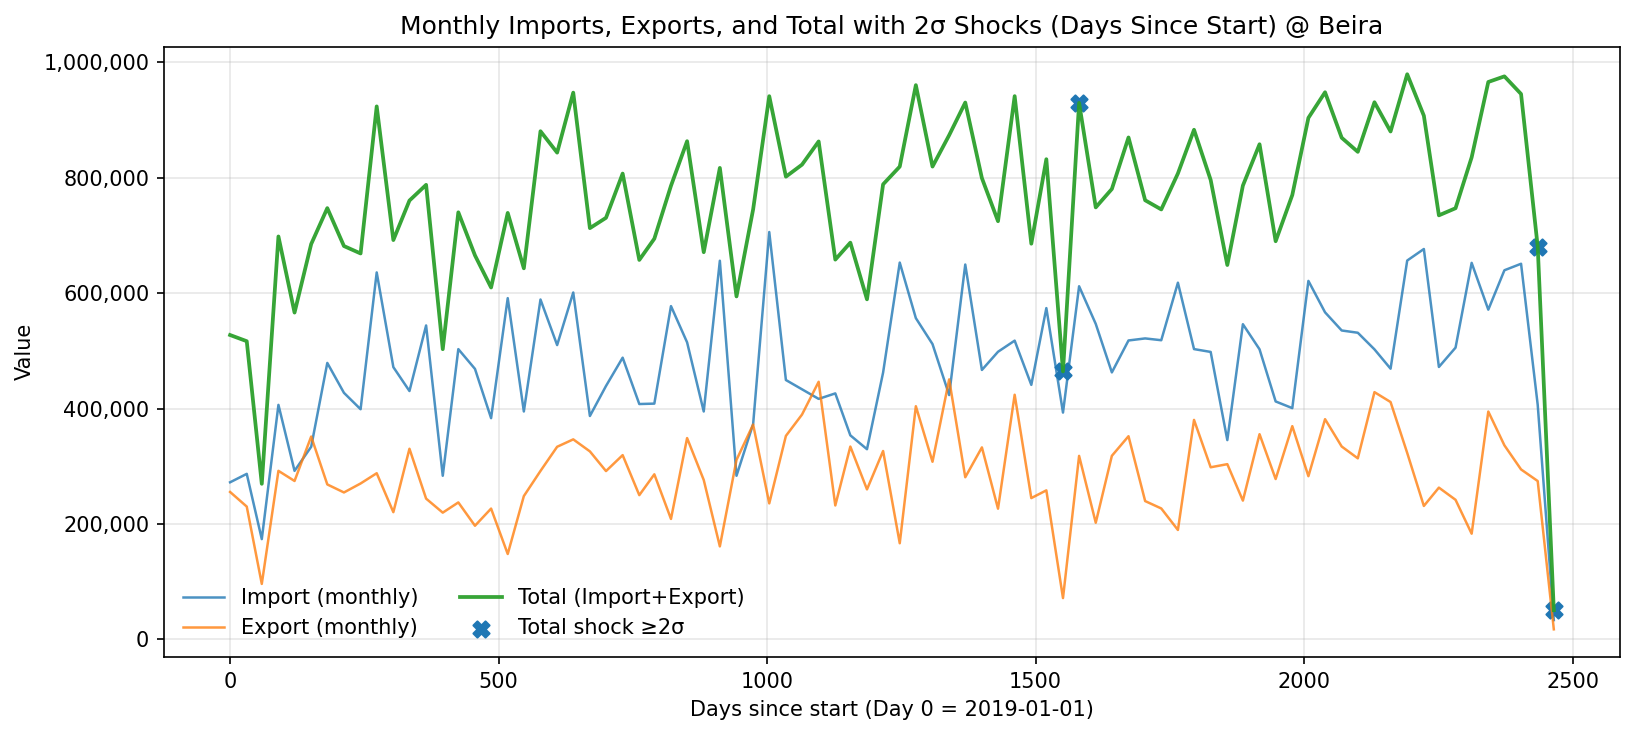

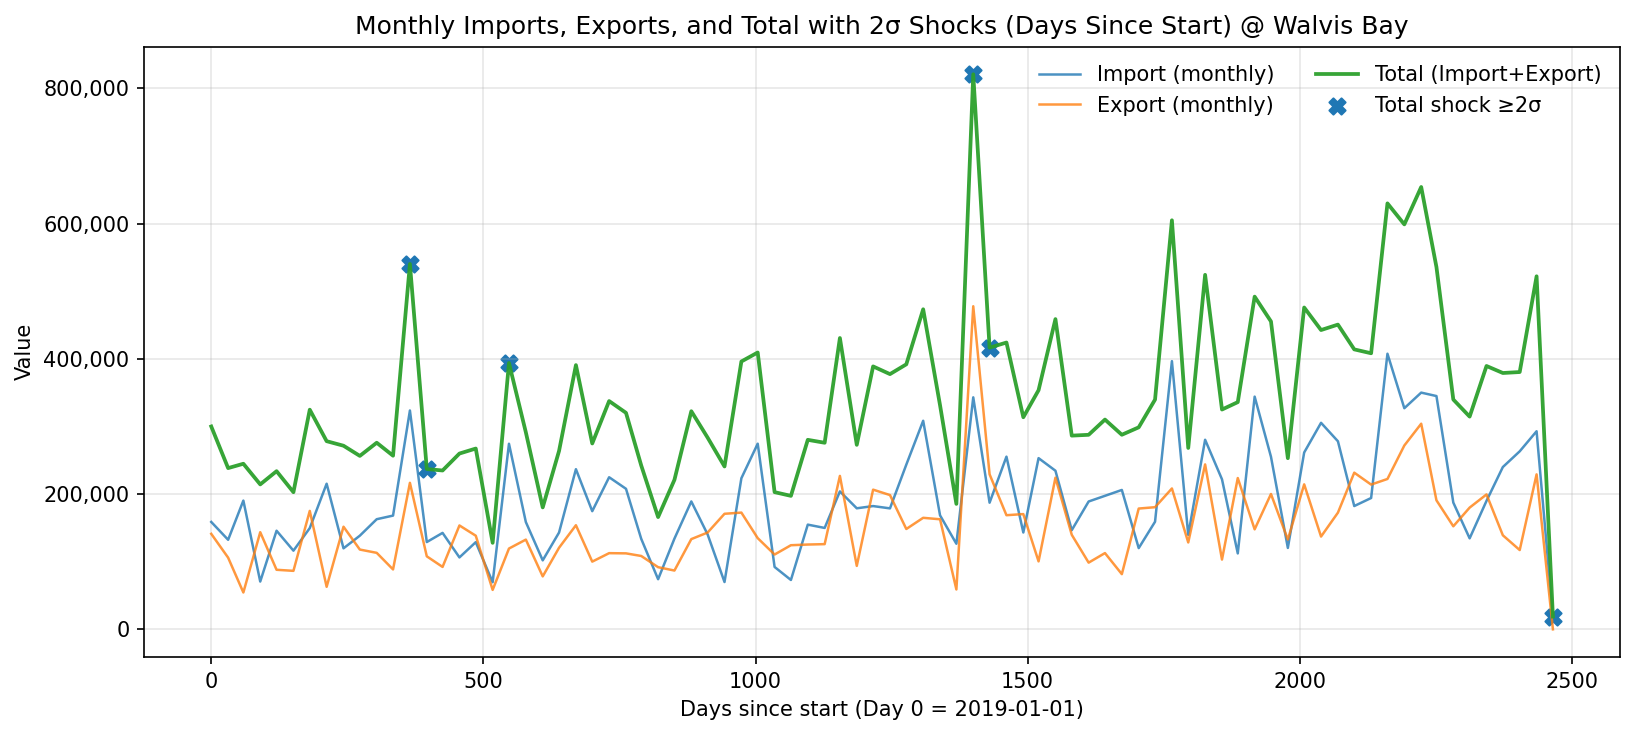

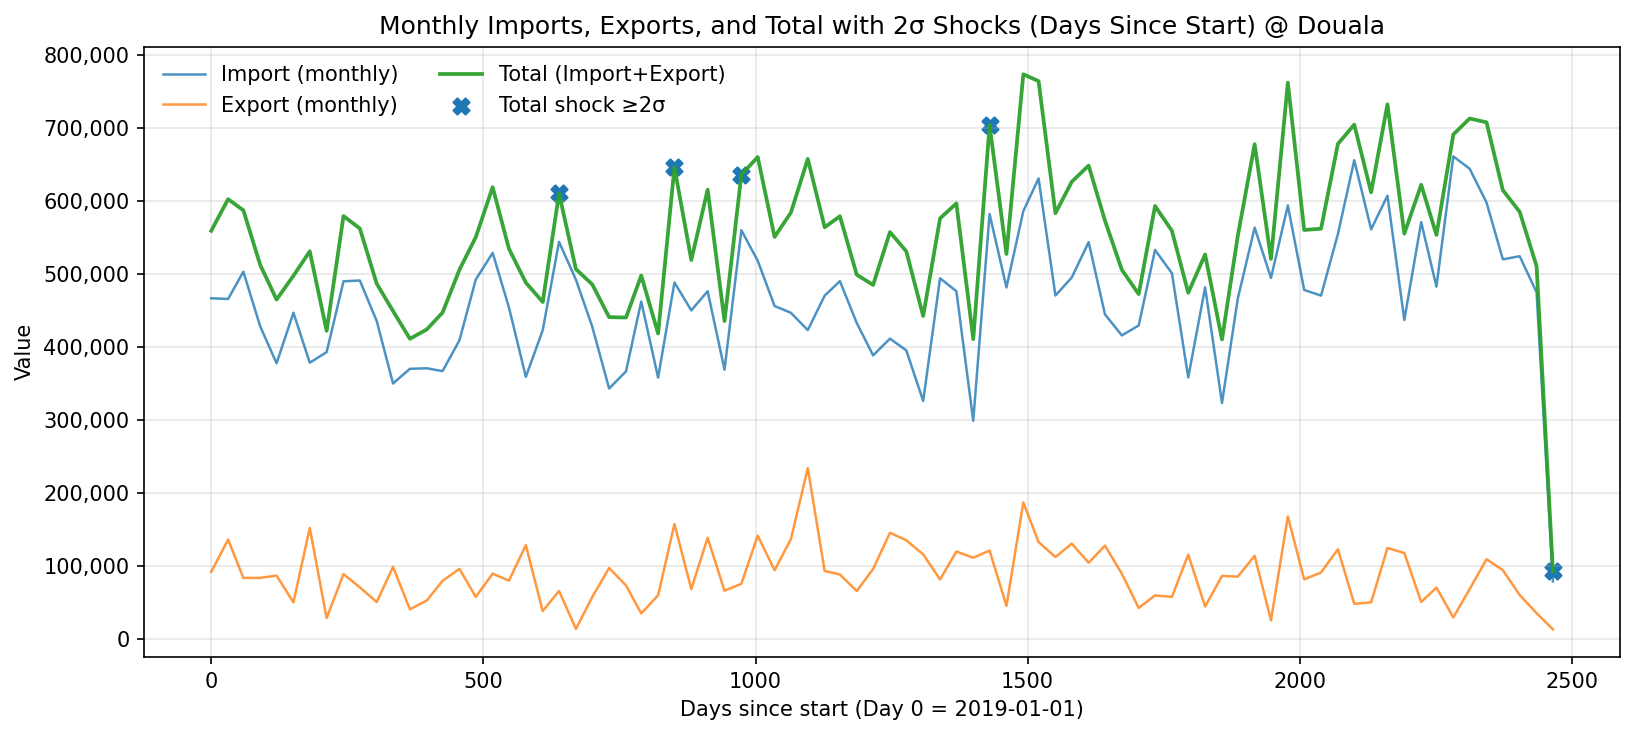

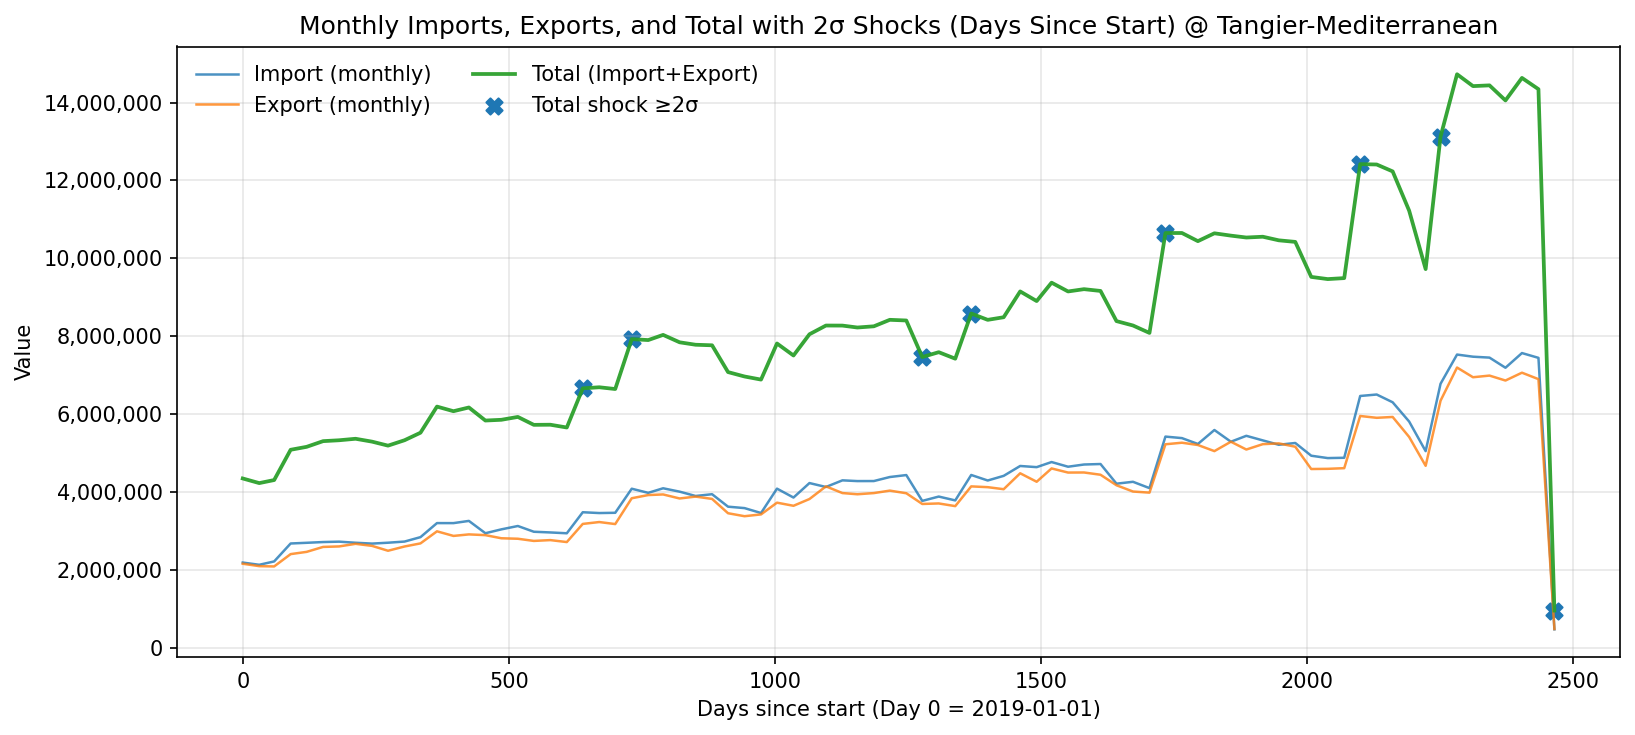

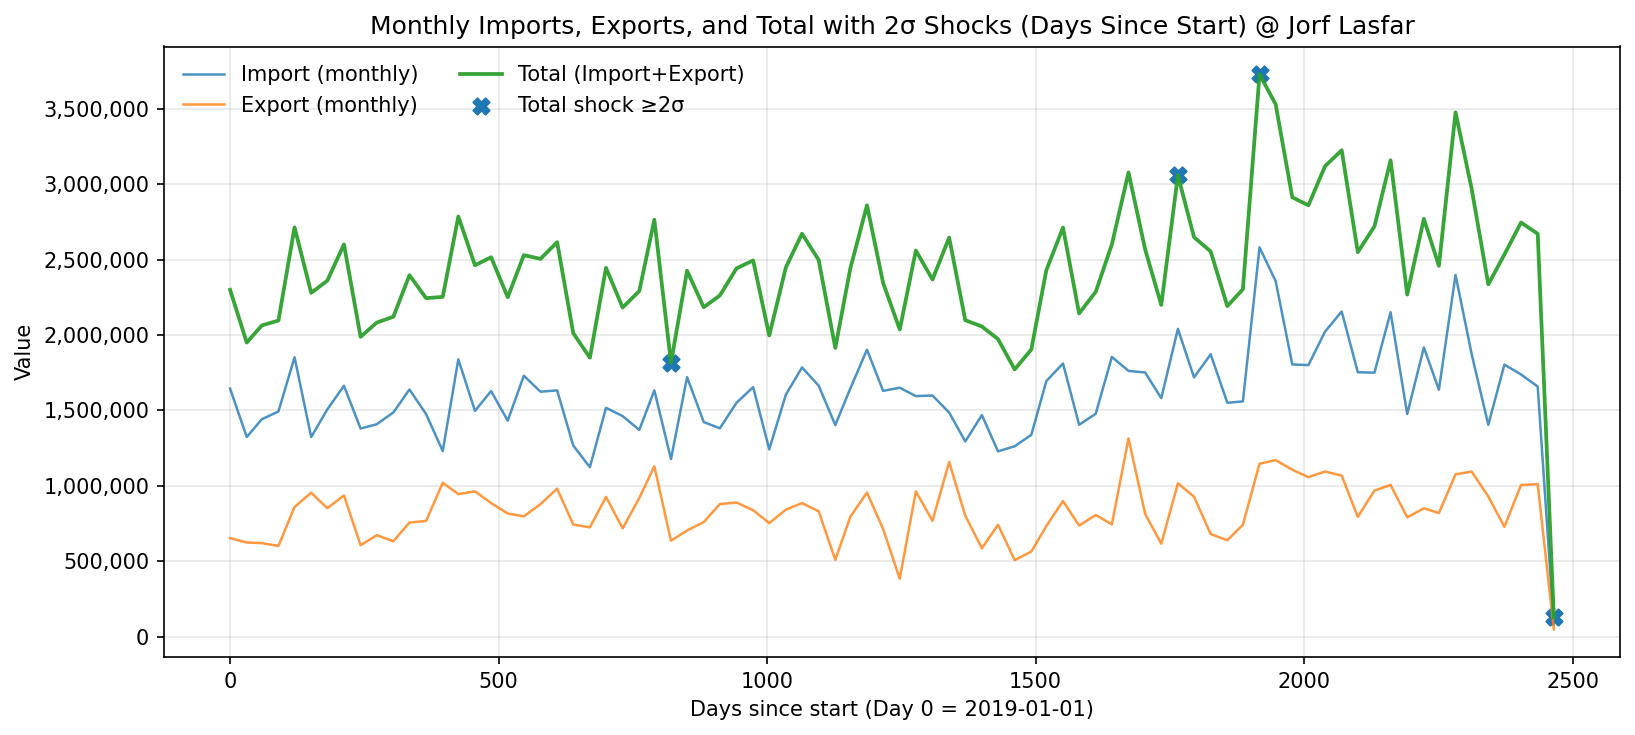

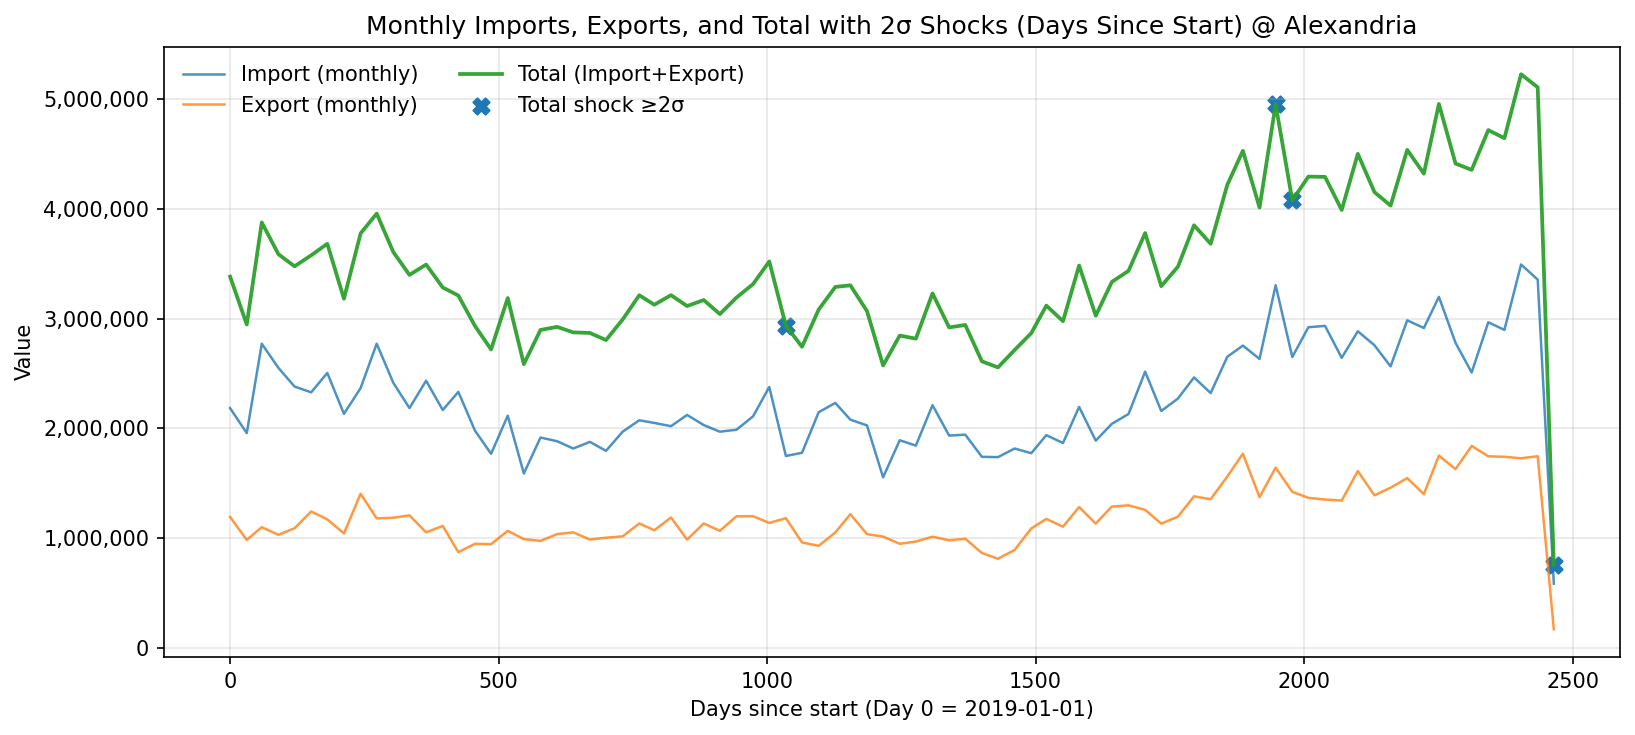

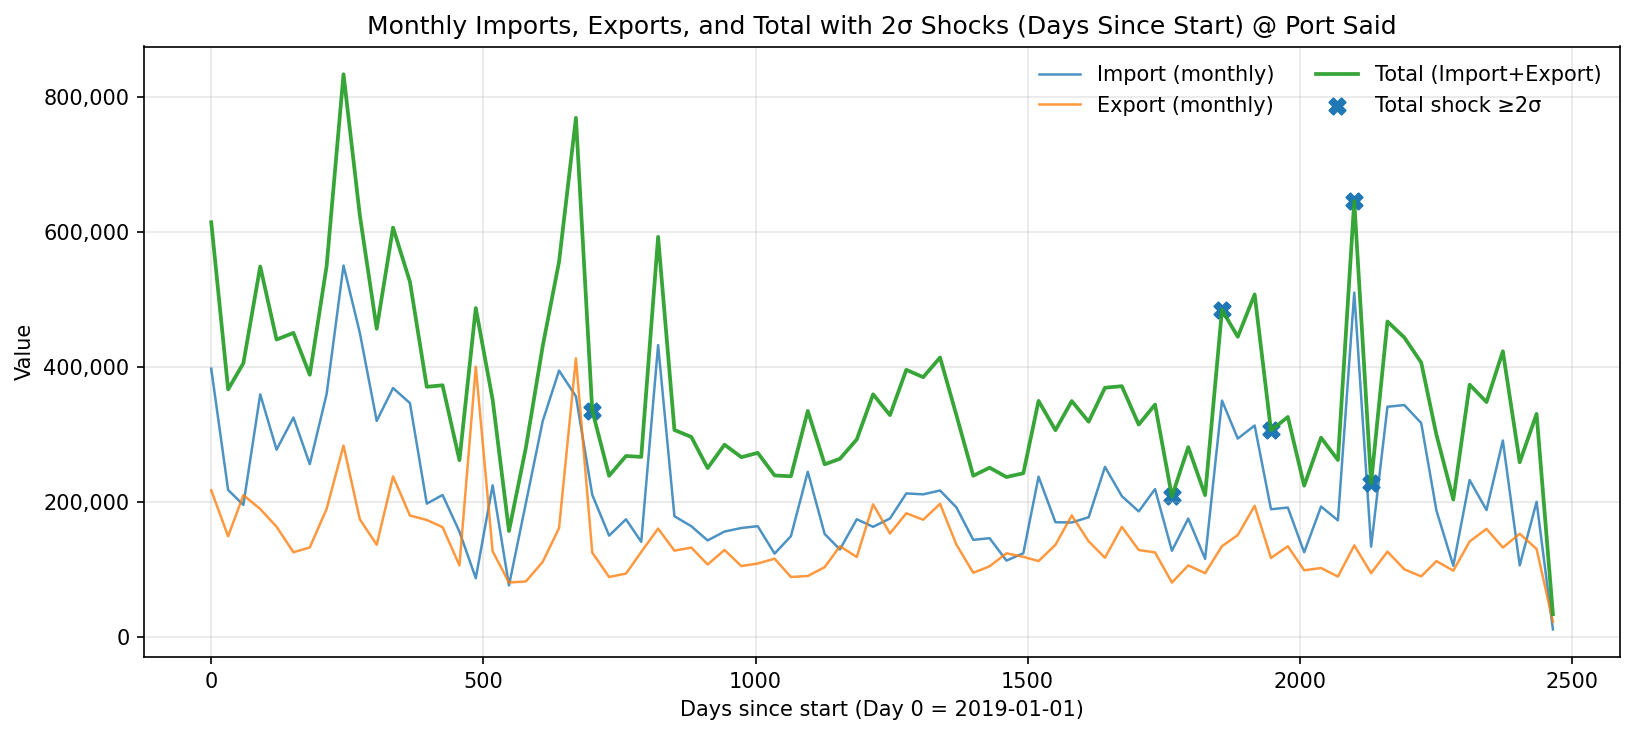

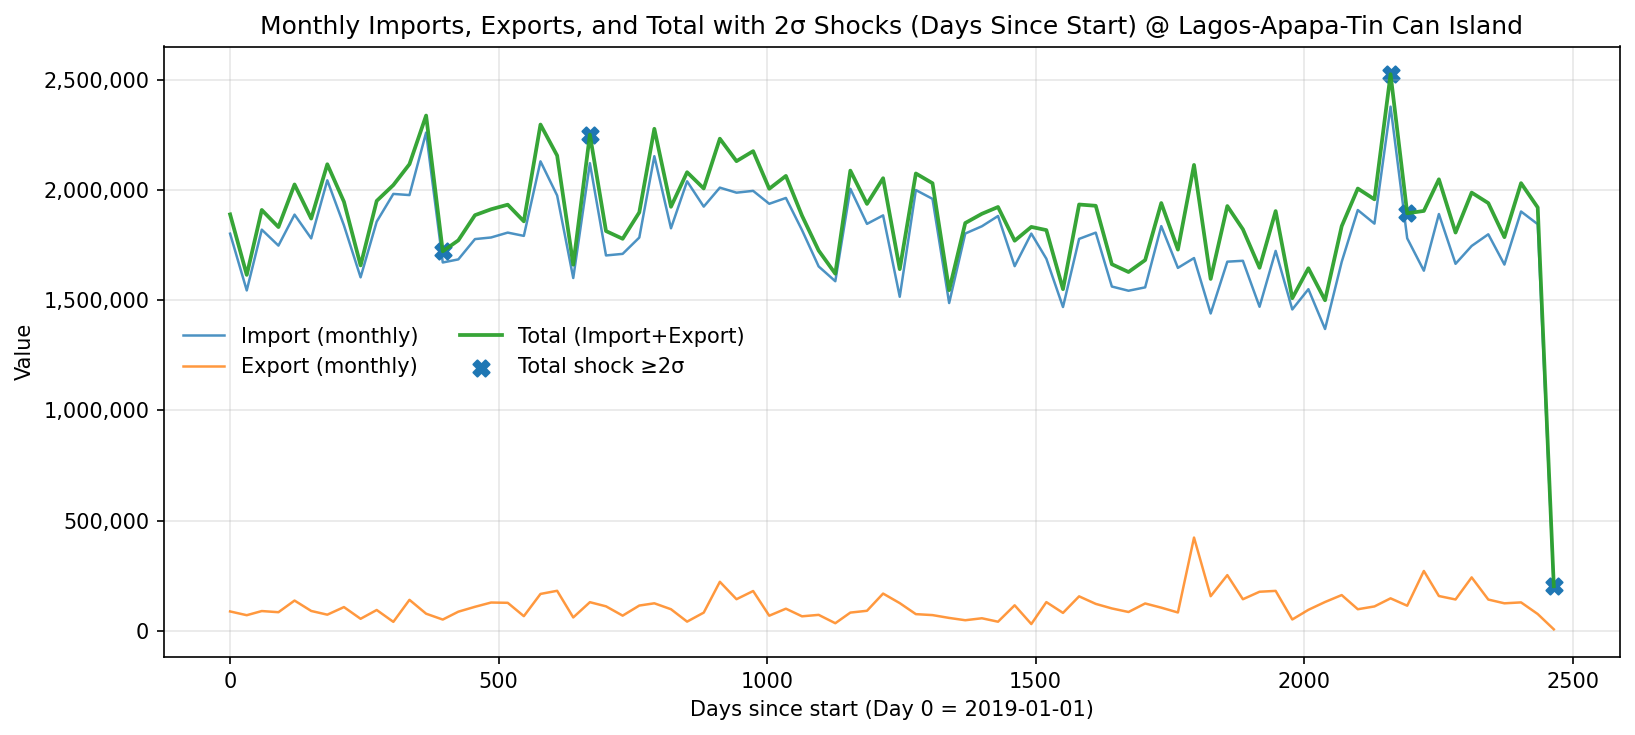

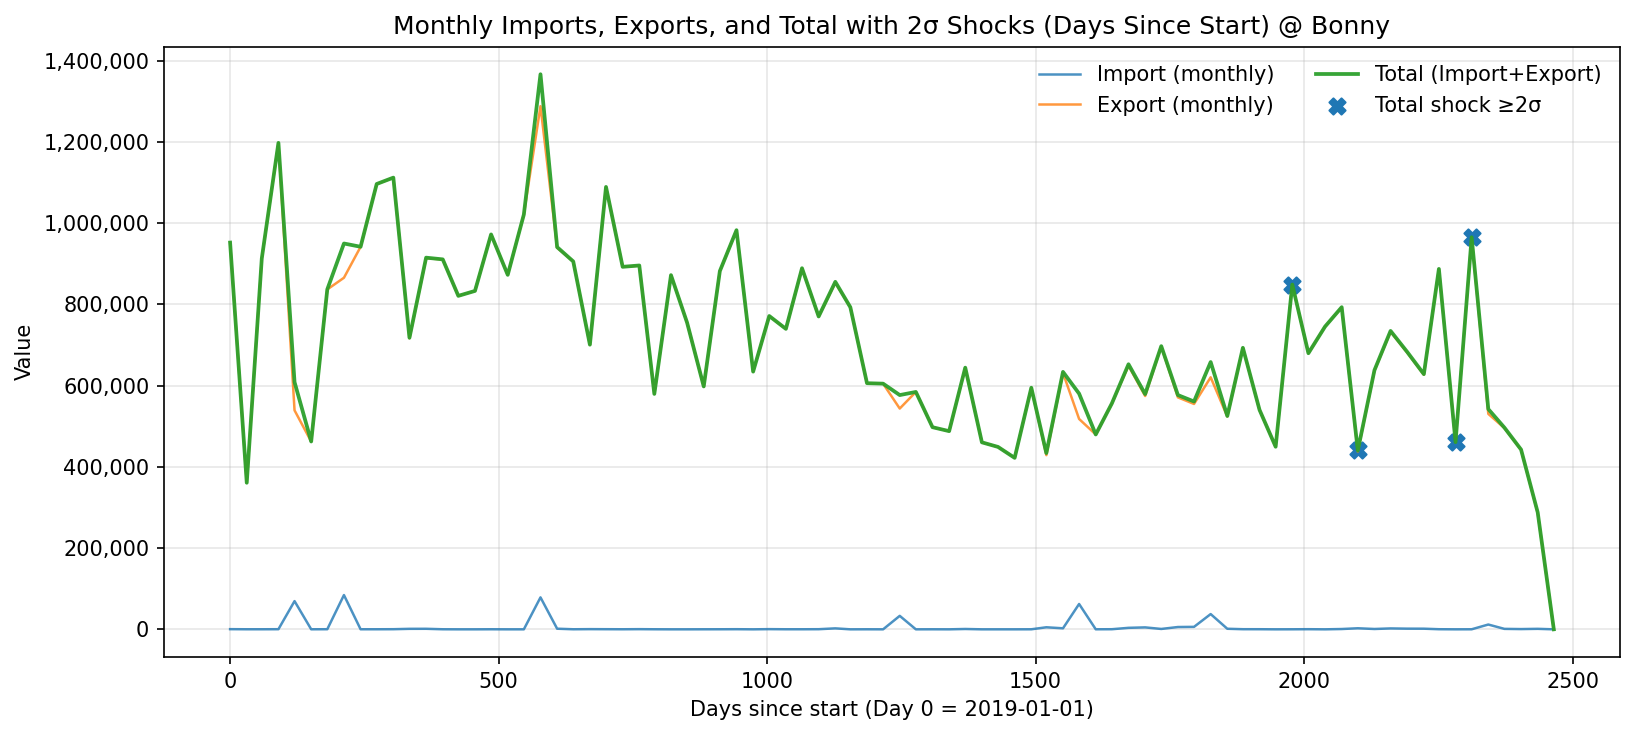

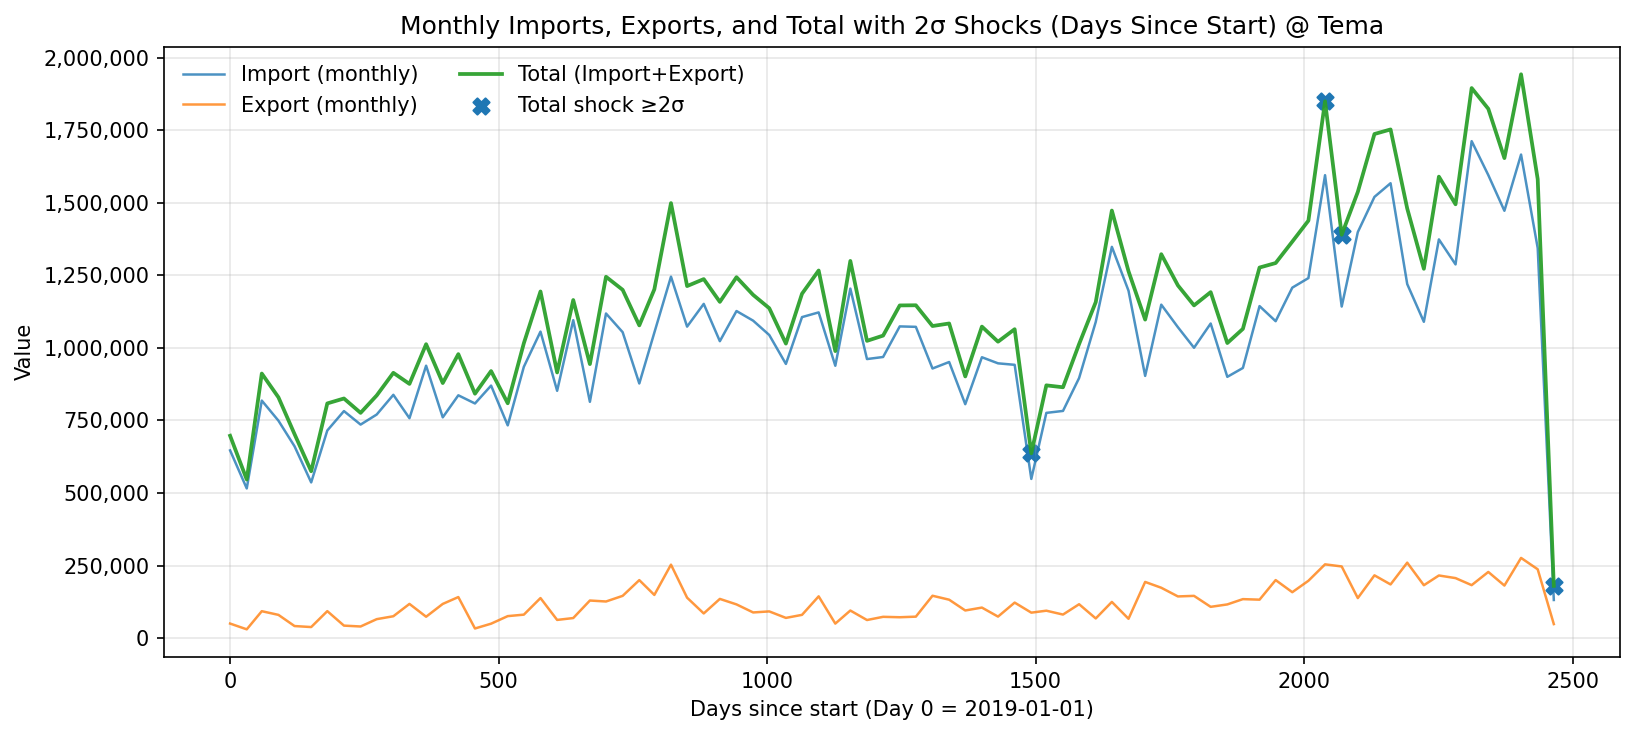

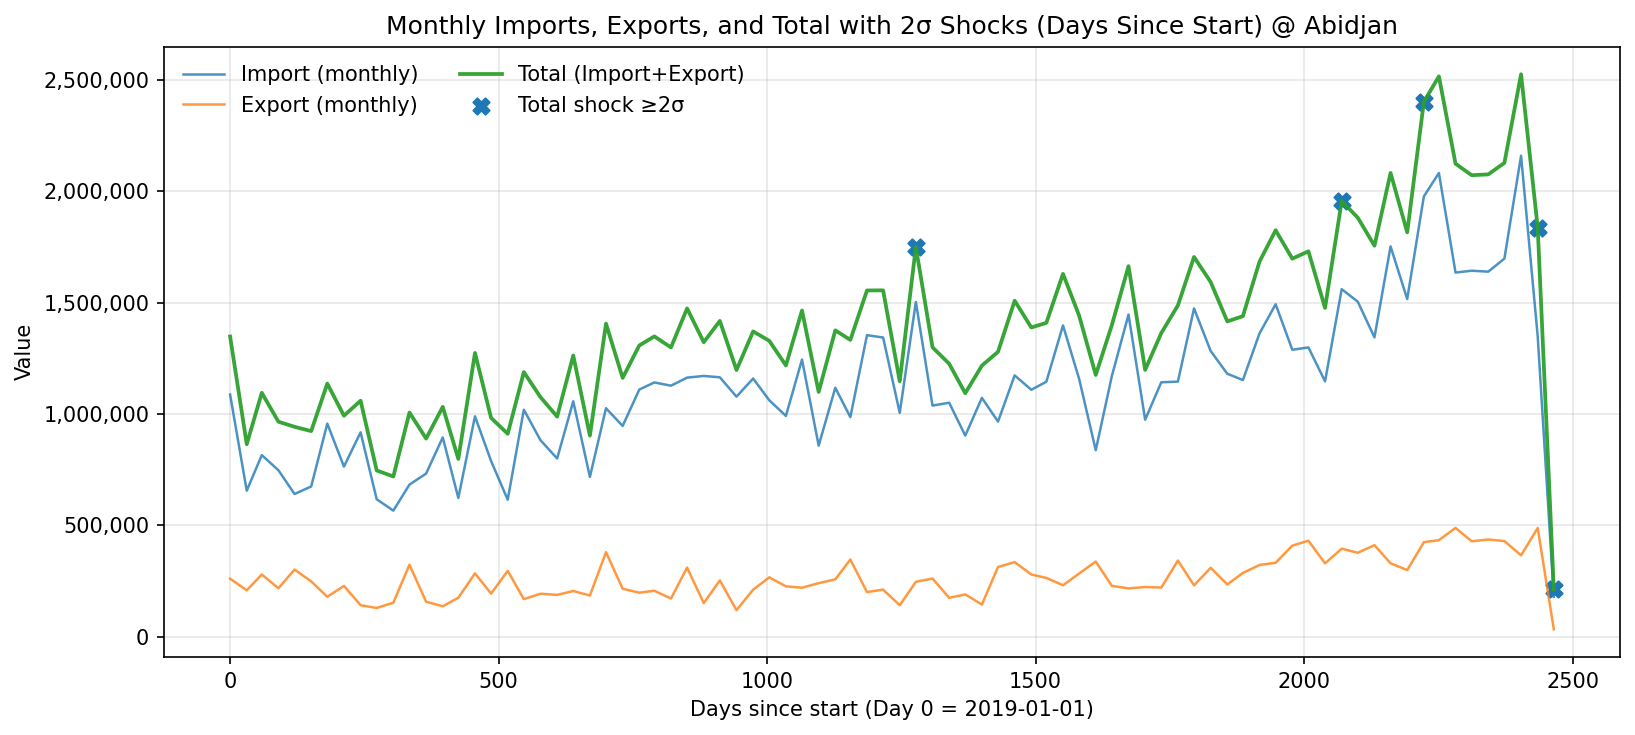

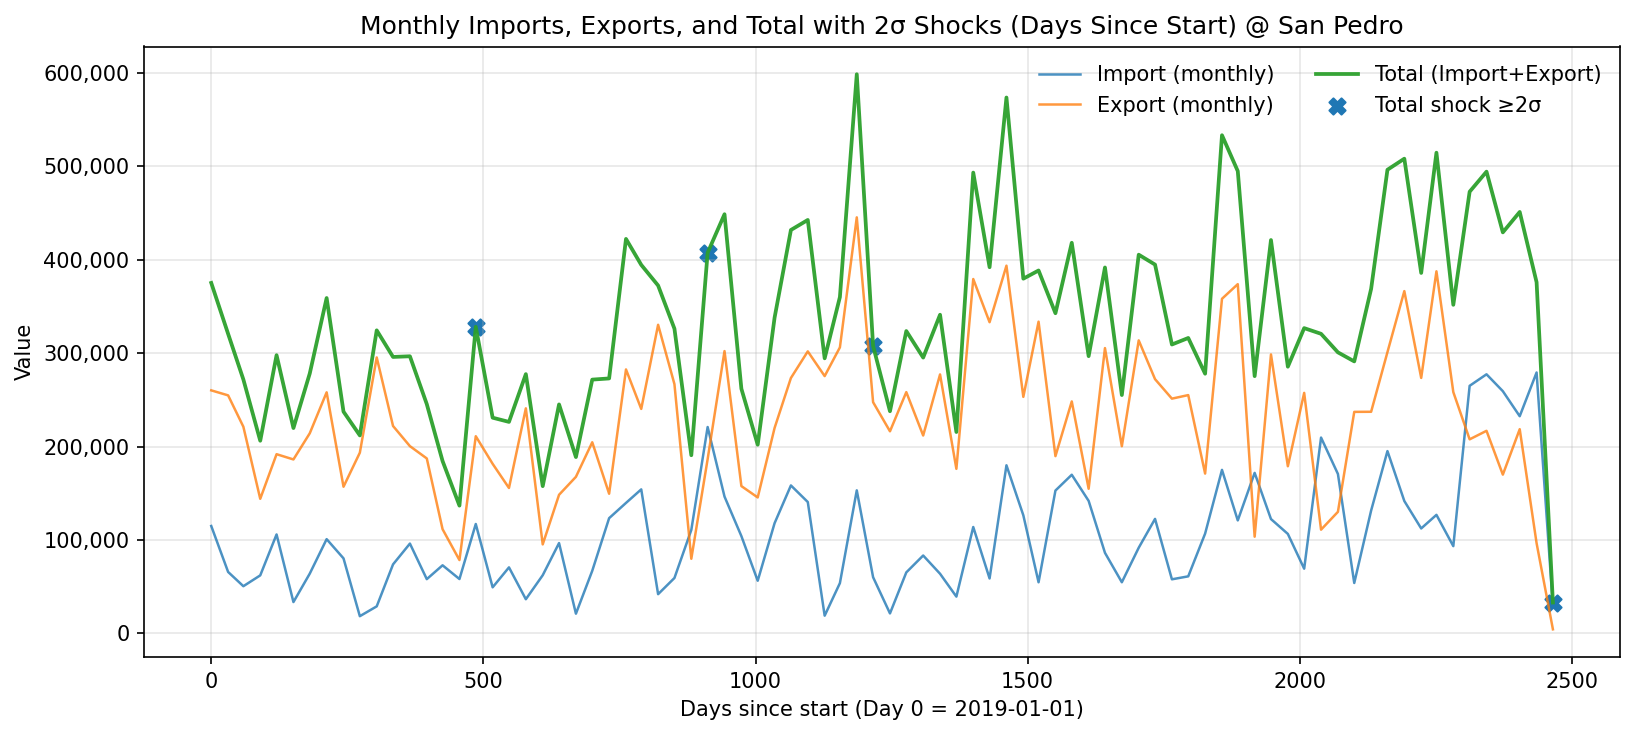

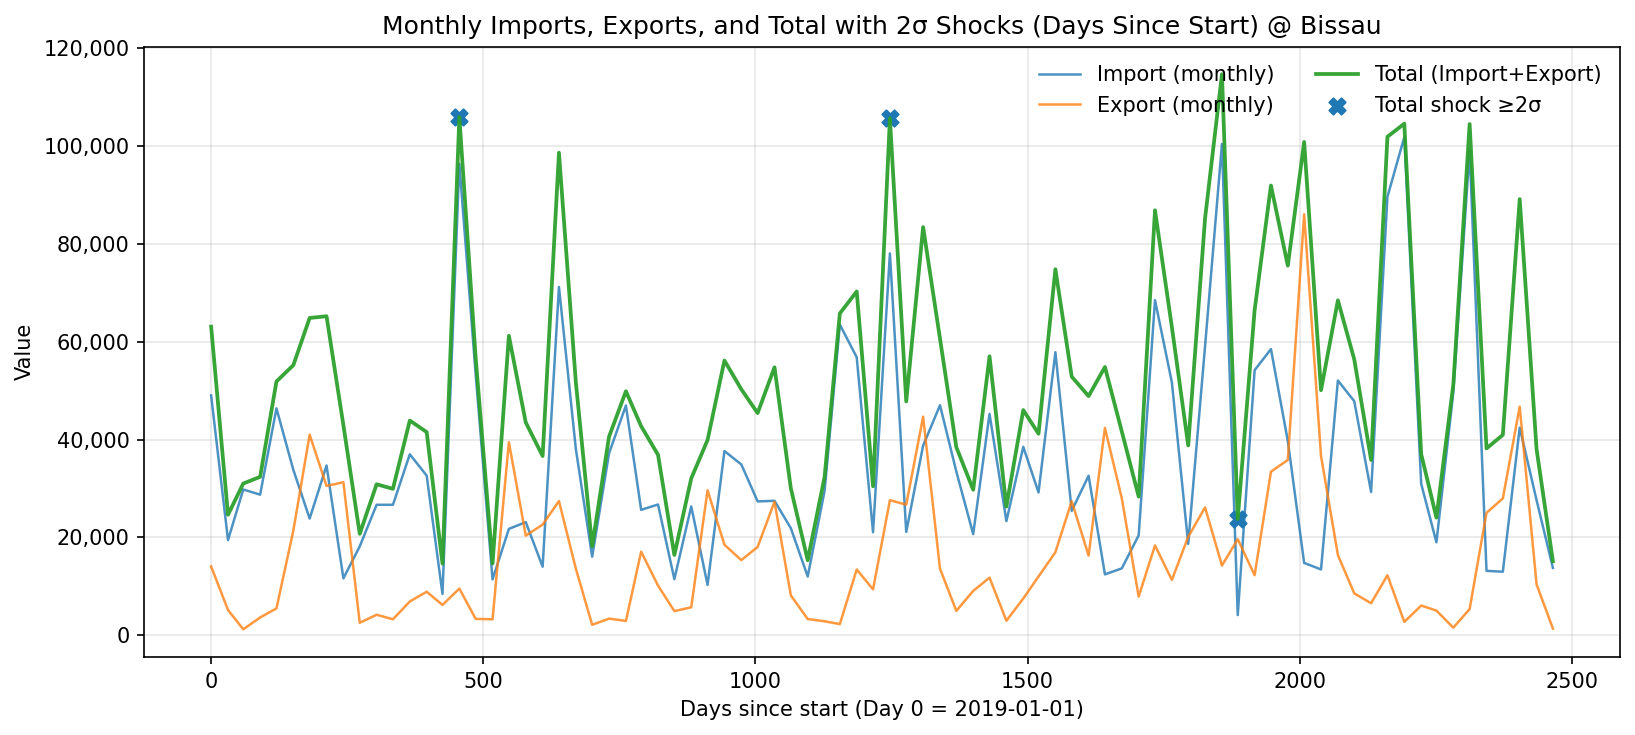

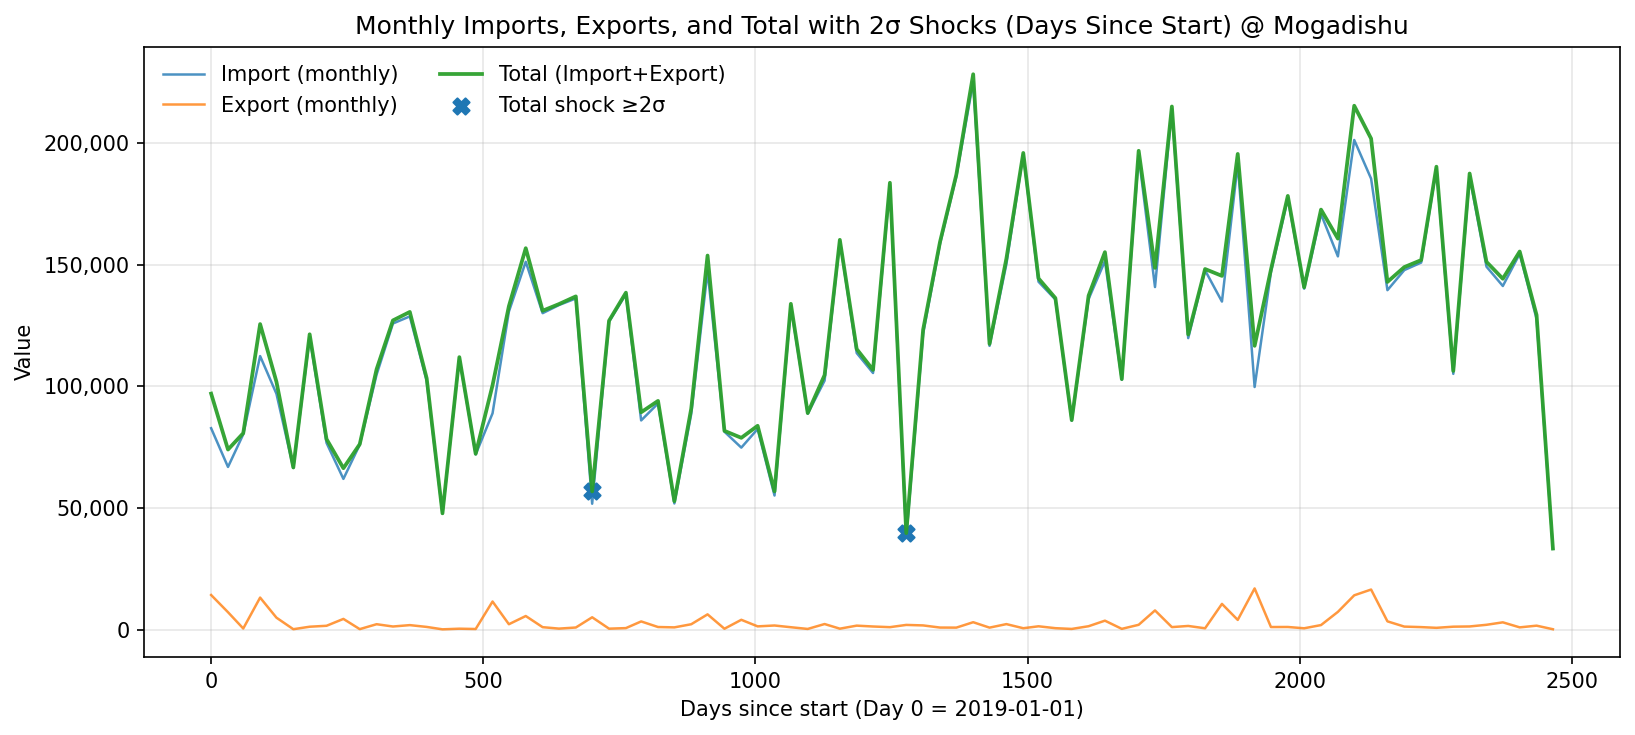

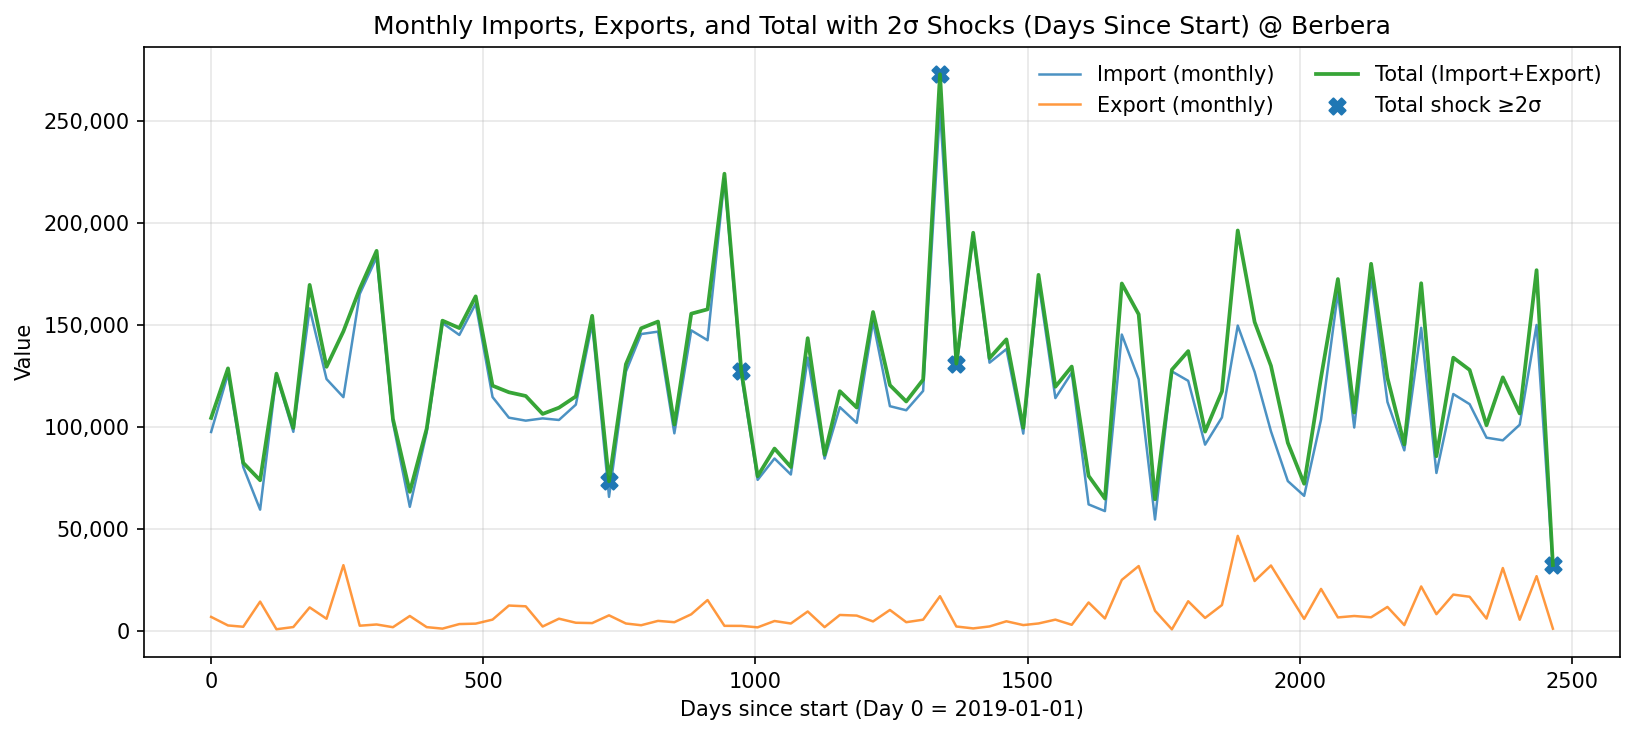

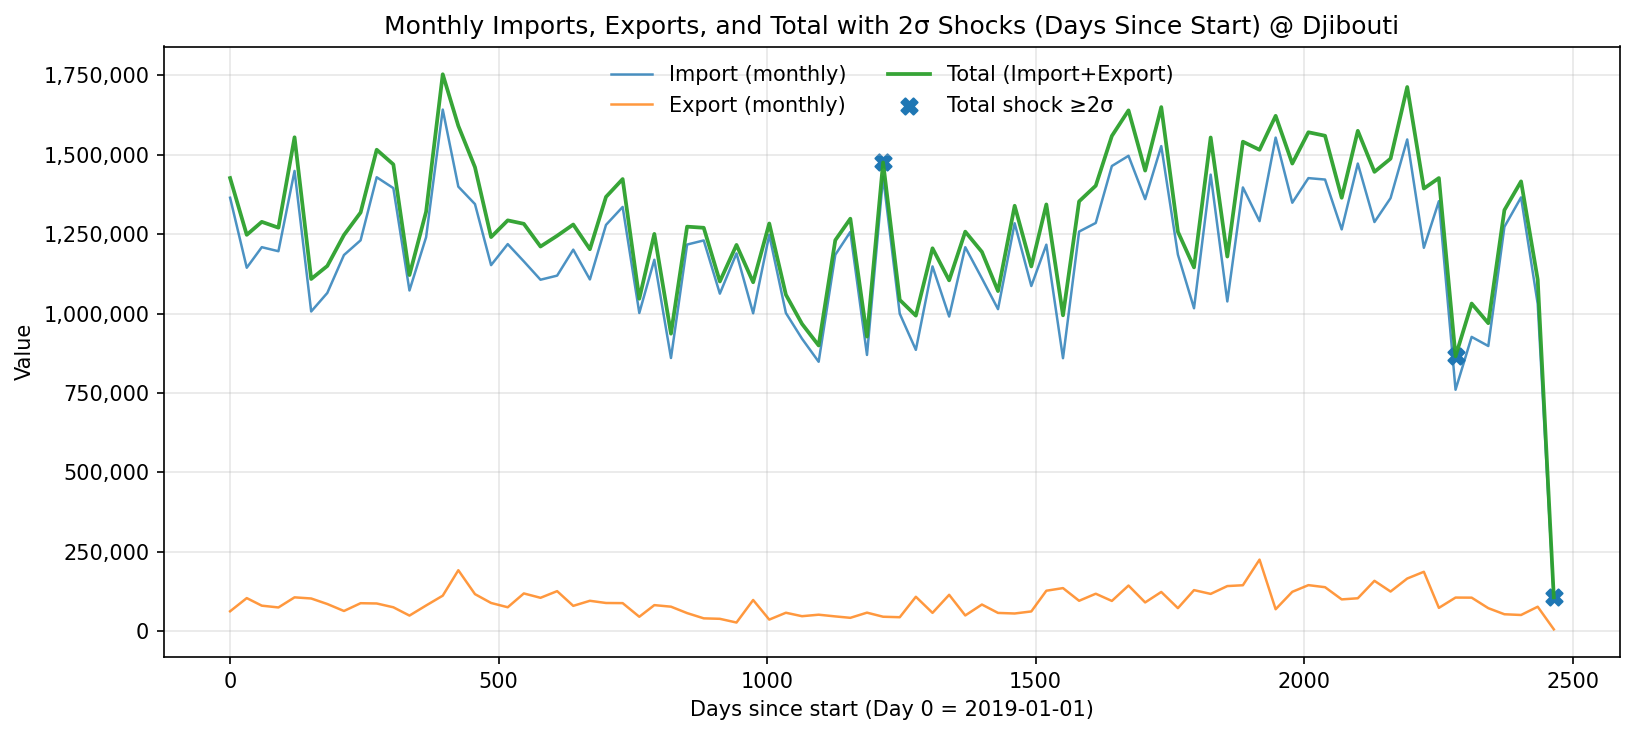

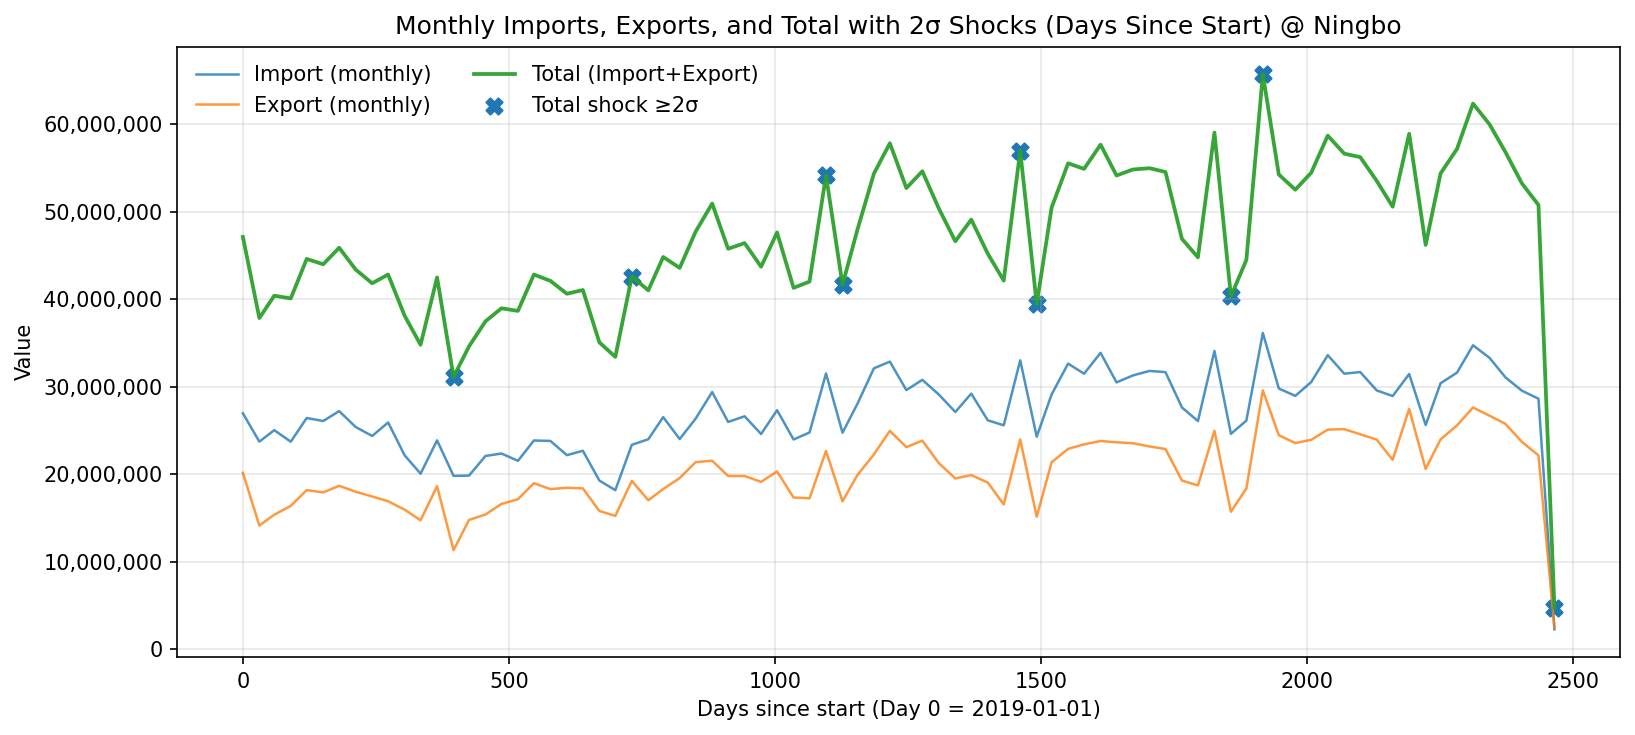

In [34]:
for city in cities:
    df = cities[city][0].copy()
    # normalize possible column name
    if "exports" in df.columns and "export" not in df.columns:
        df = df.rename(columns={"exports": "export"})
    
    need = ["date", "import", "export"]
    missing = [c for c in need if c not in df.columns]
    if missing:
        raise KeyError(f"Missing required column(s): {missing}")
    
    # Parse "YYYY/MM/DD 00:00:00+00" -> datetime (prevents 1971 issue)
    df["date"] = pd.to_datetime(
        df["date"].astype(str).str.slice(0, 10),  # keep YYYY/MM/DD
        format="%Y/%m/%d",
        errors="raise"
    )
    df = df.sort_values("date")
    
    # -------- 2) Monthly totals --------
    monthly = (
        df.set_index("date")[["import", "export"]]
          .resample("MS").sum()
    )
    
    monthly["total"] = monthly["import"] + monthly["export"]
    
    # -------- 3) Shocks based on TOTAL only (2σ) --------
    ROLL_WINDOW = 24           # months used to estimate typical change
    USE_PERCENT = False        # set True to use percent changes
    
    chg_total = monthly["total"].pct_change() if USE_PERCENT else monthly["total"].diff()
    mu  = chg_total.rolling(ROLL_WINDOW, min_periods=max(6, ROLL_WINDOW//2)).mean()
    sig = chg_total.rolling(ROLL_WINDOW, min_periods=max(6, ROLL_WINDOW//2)).std(ddof=0)
    
    z_total = (chg_total - mu) / sig
    mask_2sigma = z_total.abs() >= 2.0
    
    # Tidy table of total shocks (optional)
    total_shocks = (
        pd.DataFrame({
            "date": monthly.index,
            "total": monthly["total"].values,
            "MoM_change_total": chg_total.values,
            "z_total": z_total.values,
            "is_2sigma": mask_2sigma.values,
        })
        .dropna(subset=["z_total"])
        .query("is_2sigma")
        .reset_index(drop=True)
    )
    
    # -------- 4) X axis as days since start --------
    t0 = monthly.index.min()
    x_days = (monthly.index - t0).days
    
    # -------- 5) Plot --------
    fig, ax = plt.subplots(figsize=(11, 5), dpi=150)
    
    # Monthly lines
    ax.plot(x_days, monthly["import"].values, lw=1.2, alpha=0.8, label="Import (monthly)")
    ax.plot(x_days, monthly["export"].values, lw=1.2, alpha=0.8, label="Export (monthly)")
    ax.plot(x_days, monthly["total"].values,  lw=1.8, alpha=0.95, label="Total (Import+Export)")
    
    # Shock markers (based on TOTAL only)
    m = mask_2sigma.reindex(monthly.index, fill_value=False).values
    ax.scatter(x_days[m], monthly["total"].values[m], s=60, marker="X", label="Total shock ≥2σ")
    
    ax.set_title("Monthly Imports, Exports, and Total with 2σ Shocks (Days Since Start) @ " + city)
    ax.set_xlabel(f"Days since start (Day 0 = {t0:%Y-%m-%d})")
    ax.set_ylabel("Value")
    ax.yaxis.set_major_formatter(FuncFormatter(lambda v, _ : f"{int(v):,}"))
    ax.grid(True, which="both", alpha=0.3)
    ax.legend(frameon=False, ncol=2)
    plt.tight_layout()
    plt.show()

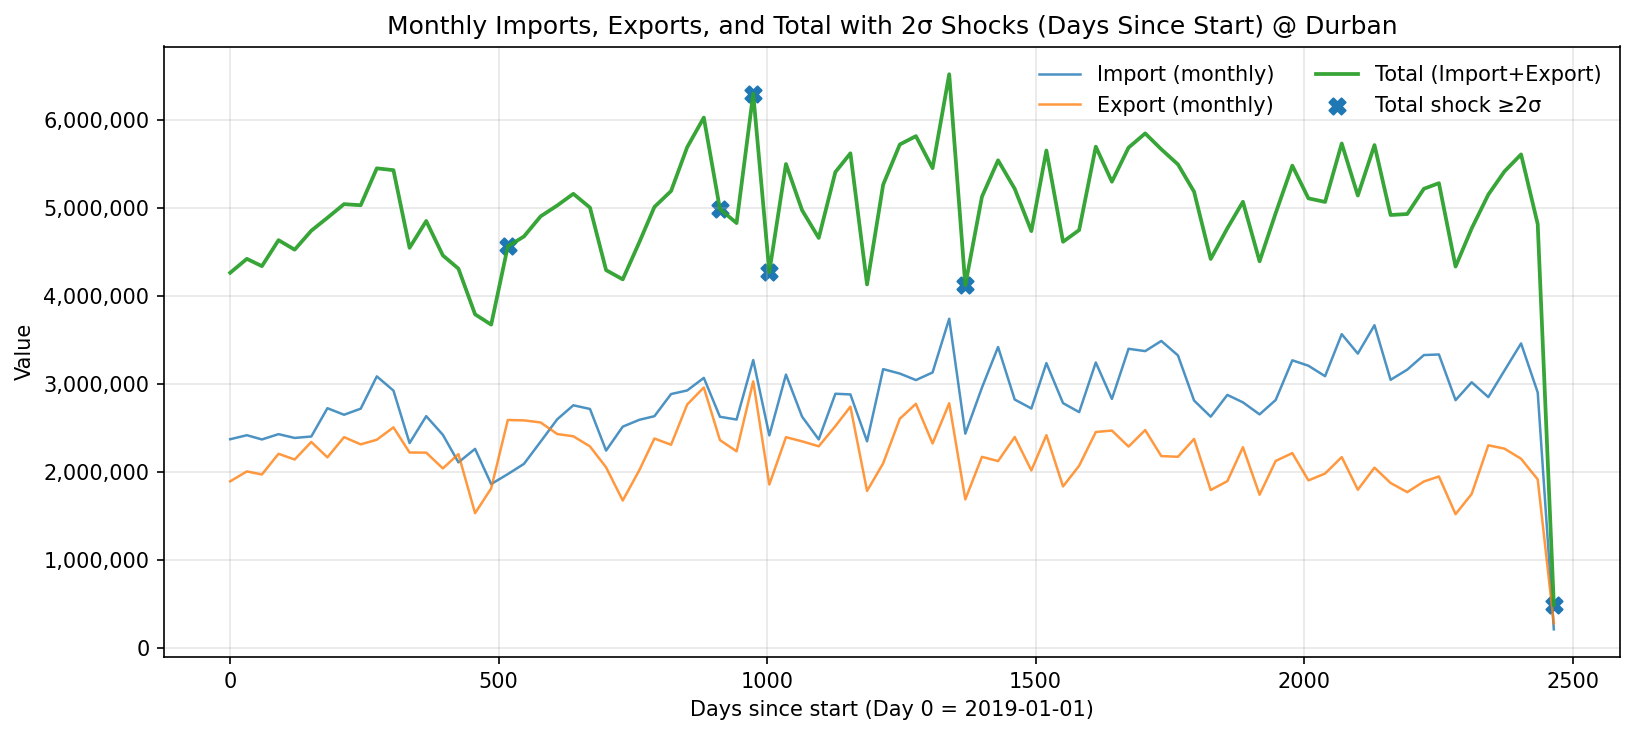

In [29]:
df = durban.copy()

# normalize possible column name
if "exports" in df.columns and "export" not in df.columns:
    df = df.rename(columns={"exports": "export"})

need = ["date", "import", "export"]
missing = [c for c in need if c not in df.columns]
if missing:
    raise KeyError(f"Missing required column(s): {missing}")

# Parse "YYYY/MM/DD 00:00:00+00" -> datetime (prevents 1971 issue)
df["date"] = pd.to_datetime(
    df["date"].astype(str).str.slice(0, 10),  # keep YYYY/MM/DD
    format="%Y/%m/%d",
    errors="raise"
)
df = df.sort_values("date")

# -------- 2) Monthly totals --------
monthly = (
    df.set_index("date")[["import", "export"]]
      .resample("MS").sum()
)

monthly["total"] = monthly["import"] + monthly["export"]

# -------- 3) Shocks based on TOTAL only (2σ) --------
ROLL_WINDOW = 24           # months used to estimate typical change
USE_PERCENT = False        # set True to use percent changes

chg_total = monthly["total"].pct_change() if USE_PERCENT else monthly["total"].diff()
mu  = chg_total.rolling(ROLL_WINDOW, min_periods=max(6, ROLL_WINDOW//2)).mean()
sig = chg_total.rolling(ROLL_WINDOW, min_periods=max(6, ROLL_WINDOW//2)).std(ddof=0)

z_total = (chg_total - mu) / sig
mask_2sigma = z_total.abs() >= 2.0

# Tidy table of total shocks (optional)
total_shocks = (
    pd.DataFrame({
        "date": monthly.index,
        "total": monthly["total"].values,
        "MoM_change_total": chg_total.values,
        "z_total": z_total.values,
        "is_2sigma": mask_2sigma.values,
    })
    .dropna(subset=["z_total"])
    .query("is_2sigma")
    .reset_index(drop=True)
)

# -------- 4) X axis as days since start --------
t0 = monthly.index.min()
x_days = (monthly.index - t0).days

# -------- 5) Plot --------
fig, ax = plt.subplots(figsize=(11, 5), dpi=150)

# Monthly lines
ax.plot(x_days, monthly["import"].values, lw=1.2, alpha=0.8, label="Import (monthly)")
ax.plot(x_days, monthly["export"].values, lw=1.2, alpha=0.8, label="Export (monthly)")
ax.plot(x_days, monthly["total"].values,  lw=1.8, alpha=0.95, label="Total (Import+Export)")

# Shock markers (based on TOTAL only)
m = mask_2sigma.reindex(monthly.index, fill_value=False).values
ax.scatter(x_days[m], monthly["total"].values[m], s=60, marker="X", label="Total shock ≥2σ")

ax.set_title("Monthly Imports, Exports, and Total with 2σ Shocks (Days Since Start) @ Durban")
ax.set_xlabel(f"Days since start (Day 0 = {t0:%Y-%m-%d})")
ax.set_ylabel("Value")
ax.yaxis.set_major_formatter(FuncFormatter(lambda v, _ : f"{int(v):,}"))
ax.grid(True, which="both", alpha=0.3)
ax.legend(frameon=False, ncol=2)
plt.tight_layout()
plt.show()

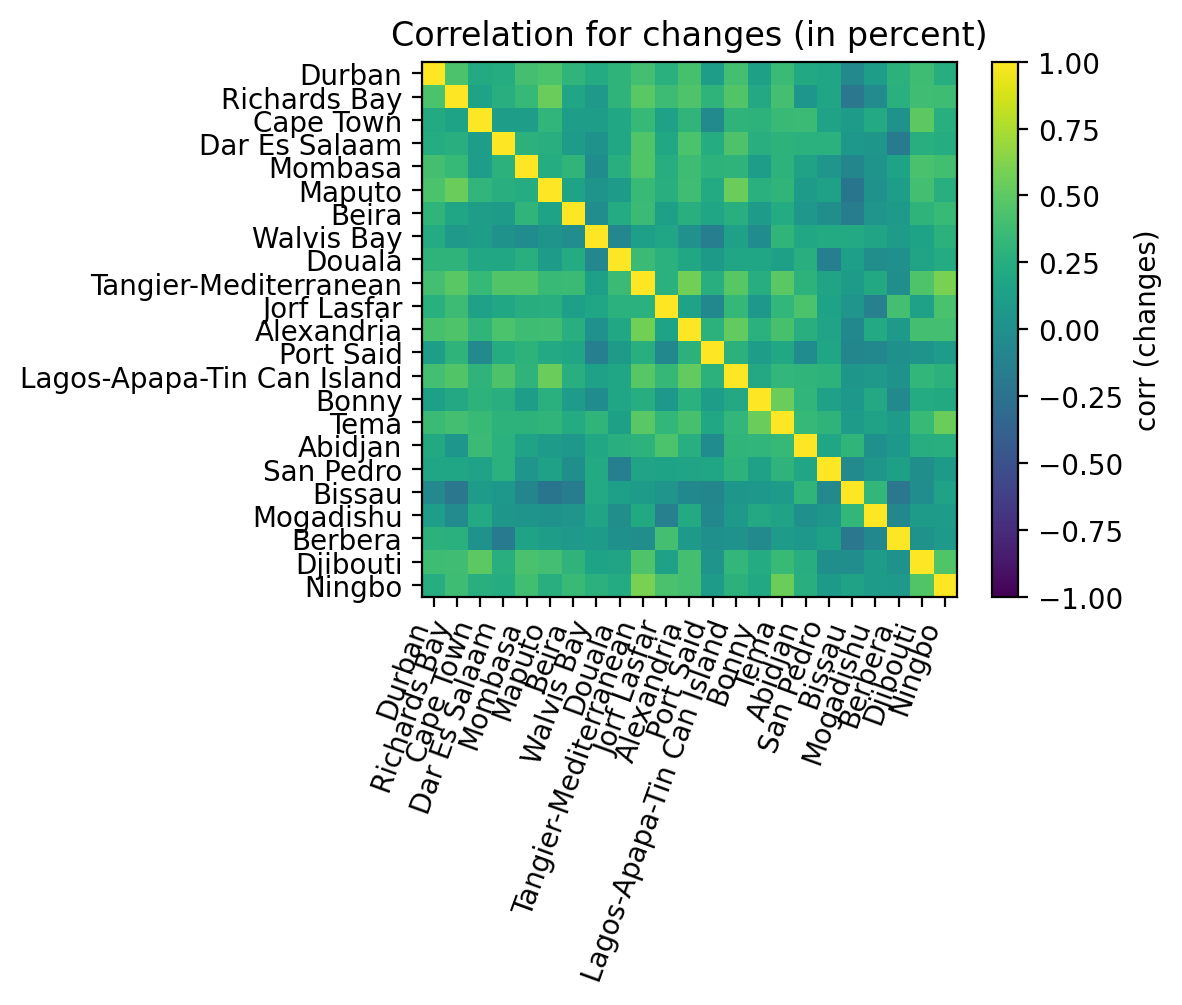

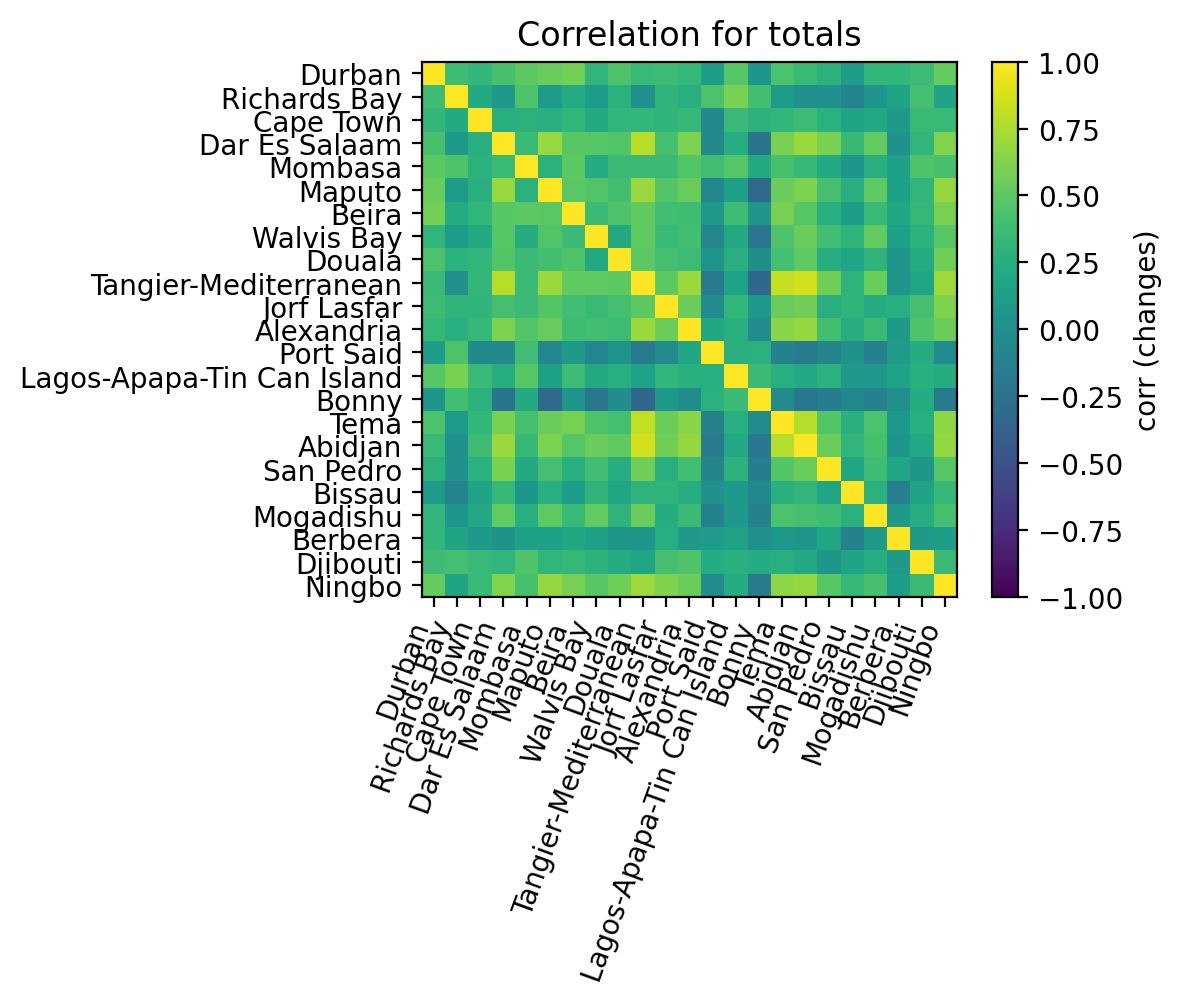

In [36]:
from functools import reduce

ROLL_WINDOW = 24
USE_PERCENT = True

all_totals = {}        # monthly total per city
all_changes = {}       # monthly change per city (for “shock-ish” corr)

for city in cities:   # cities is your dict: {city_name: df}
    df = cities[city][0].copy()


    need = ["date", "import", "export"]
    missing = [c for c in need if c not in df.columns]
    if missing:
        raise KeyError(f"{city}: missing {missing}")

    # dates
    df["date"] = pd.to_datetime(
        df["date"].astype(str).str.slice(0, 10),
        format="%Y/%m/%d",
        errors="raise"
    )
    df = df.sort_values("date")

    # monthly aggregation
    monthly = (
        df.set_index("date")[["import", "export"]]
          .resample("MS").sum()
    )
    monthly["total"] = monthly["import"] + monthly["export"]

    # store TOTAL series
    all_totals[city] = monthly["total"]

    # also store change series (often better for corr)
    chg = monthly["total"].pct_change() if USE_PERCENT else monthly["total"].diff()
    all_changes[city] = chg

    # align on the monthly index (outer join so ports with different start dates still appear)
    totals_df = pd.concat(all_totals, axis=1)   # columns will be a MultiIndex (city,). Let's flatten:
    totals_df.columns = totals_df.columns.get_level_values(0)
    
    changes_df = pd.concat(all_changes, axis=1)
    changes_df.columns = changes_df.columns.get_level_values(0)
    
# 1) Correlation of levels (volumes)
corr_totals = totals_df.corr()

# 2) Correlation of changes (usually more meaningful)
corr_changes = changes_df.corr()

#Correlation for changes
fig, ax = plt.subplots(figsize=(6, 5), dpi=200)
im = ax.imshow(corr_changes, vmin=-1, vmax=1)
ax.set_xticks(range(len(corr_changes.columns)))
ax.set_xticklabels(corr_changes.columns, rotation=70, ha="right")
ax.set_yticks(range(len(corr_changes.index)))
ax.set_yticklabels(corr_changes.index)
fig.colorbar(im, ax=ax, label="corr (changes)")
plt.title("Correlation for changes (in percent)")
plt.tight_layout()
plt.show()

#Correlation for totals
fig, ax = plt.subplots(figsize=(6, 5), dpi=200)
im = ax.imshow(corr_totals, vmin=-1, vmax=1)
ax.set_xticks(range(len(corr_totals.columns)))
ax.set_xticklabels(corr_totals.columns, rotation=70, ha="right")
ax.set_yticks(range(len(corr_totals.index)))
ax.set_yticklabels(corr_totals.index)
fig.colorbar(im, ax=ax, label="corr (changes)")
plt.title("Correlation for totals")
plt.tight_layout()
plt.show()

In [ ]:
print(corr_totals.round(2))


In [ ]:
for c in citiesL:
    print(cities[c][1])

In [ ]:
#To Display port
# for c in citiesL:
#     ticker_symbol = cities[c][1]
#     # Convert ticker_symbol to string if it's a DataFrame
#     if isinstance(ticker_symbol, pd.DataFrame):
#         ticker_symbol = str(ticker_symbol)  # Convert DataFrame to string
    
#     start_date = "2019-01-01"
#     end_date = "2025-05-18"
#     forex_data = yf.download(ticker_symbol, start=start_date, end=end_date)
    
#     # assuming you already have: forex_data = yf.download(ticker_symbol, start=start_date, end=end_date)
    
#     s = forex_data['Close'].dropna()
#     ma = s.rolling(30, min_periods=1).mean()  # ~30 trading days ≈ 1.5 months
    
#     fig, ax = plt.subplots(figsize=(12, 6), dpi=160)
    
#     # main line + optional rolling mean
#     ax.plot(s.index, s.values, linewidth=1.6, label="Close")
#     ax.plot(ma.index, ma.values, linewidth=1.2, alpha=0.8, linestyle="--", label="30-day Moving Average")
    
#     # x-axis formatting: year ticks + monthly minor ticks
#     ax.xaxis.set_major_locator(mdates.YearLocator())
#     ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
#     ax.xaxis.set_minor_locator(mdates.MonthLocator())
#     for label in ax.get_xticklabels(which='major'):
#         label.set(rotation=0, ha='center')
    
#     # tidy labels/titles
#     ax.set_title(f"{ticker_symbol} — Close", pad=10)  # Now ticker_symbol is a string
#     ax.set_xlabel("Date")
#     ax.set_ylabel("Price")
    
#     # grid and margins
#     ax.grid(True, which="major", alpha=0.25)
#     ax.grid(True, which="minor", alpha=0.10)
#     ax.margins(x=0.01, y=0.05)
    
#     # de-clutter spines
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
    
#     # legend (only if you keep the MA line)
#     ax.legend(frameon=True, loc="upper left")
    
#     plt.tight_layout()
#     plt.show()

In [ ]:
top = cities["Durban"][0].copy()
top["date"] = (
    pd.to_datetime(top["date"].astype(str).str[:10], format="%Y/%m/%d", utc=True)  # parse as UTC
      .dt.tz_localize(None)                              # drop tz -> tz-naive
      .dt.normalize() 
)
top

In [ ]:
pdc = {}
for c in citiesL:
    ticker_symbol = cities[c][1]
    start_date = "2019-01-01"
    end_date = "2025-05-18"
    fx = (
    yf.download(ticker_symbol, start="2019-01-01", end="2025-10-03", progress=False)["Close"]
      .reset_index()                                     
      .rename(columns={"Date":"date"})
    )
    fx["date"] = pd.to_datetime(fx["date"]).dt.tz_localize(None).dt.normalize()

    top = cities[c][0].copy()
    top["date"] = (
    pd.to_datetime(top["date"].astype(str).str[:10], format="%Y/%m/%d", utc=True)  # parse as UTC
      .dt.tz_localize(None)                              # drop tz -> tz-naive
      .dt.normalize() 
    )

    # Now dates are aligned and merge will work:
    merged = top.merge(fx, on="date", how="left", validate="m:1")
    clean = merged.dropna(subset=[ticker_symbol]).reset_index(drop=True)
    pdc[c] = clean
pdc['Durban']

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ===== settings =====
FREQ = "MS"          # monthly start
USE_PCT = False       # True: percent changes; False: level diffs
FX_COL_FINDER = lambda cols: [c for c in cols if isinstance(c, str) and c.endswith("=X")]
FX_AGG = "mean"      # 'mean' or 'last' for monthly FX sampling

# pdc is your dict: {city_name: cleaned_df_with_import_export_and_one_FX_col}

# ---- 1) build monthly port totals and currency FX series ----------------
per_port_total = {}      # city -> monthly total (sum imports+exports)
per_currency_fx = {}     # 'ZARUSD=X' -> monthly FX (mean/last)

for city, df in pdc.items():
    df = df.copy()

    # monthly total
    monthly_total = (
        df.assign(total=df["import"].astype(float) + df["export"].astype(float))
          .set_index("date")["total"]
          .resample(FREQ).sum()
    )
    per_port_total[city] = monthly_total

    # find this DF's FX column(s) and store a currency series we can reuse
    fx_cols = FX_COL_FINDER(df.columns)
    for fx_col in fx_cols:
        fx_monthly = (df.set_index("date")[fx_col]
                        .resample(FREQ)
                        .agg(FX_AGG))       # monthly FX (mean or last)
        # keep the longest (or first) we see
        if fx_col not in per_currency_fx or fx_monthly.index.size > per_currency_fx[fx_col].index.size:
            per_currency_fx[fx_col] = fx_monthly

# optional: if you also want USD as a flat 1.0 series, uncomment:
# per_currency_fx['USDUSD=X'] = pd.Series(1.0, index=pd.date_range(
#     start=min(s.index.min() for s in per_port_total.values()),
#     end=max(s.index.max() for s in per_port_total.values()),
#     freq=FREQ))

cities = sorted(per_port_total.keys())
currencies = sorted(per_currency_fx.keys())

# ---- 2) full currency x port correlation matrix ------------------------
corr_full = pd.DataFrame(index=currencies, columns=cities, dtype=float)

for city in cities:
    total = per_port_total[city]

    for pair in currencies:
        fx = per_currency_fx[pair]

        # align to overlapping months
        df_xy = pd.concat([total.rename("total"), fx.rename("fx")], axis=1).dropna()
        if df_xy.empty or df_xy.shape[0] < 3:
            corr_full.loc[pair, city] = np.nan
            continue

        if USE_PCT:
            x = df_xy["total"].pct_change()
            y = df_xy["fx"].pct_change()
        else:
            x = df_xy["total"].diff()
            y = df_xy["fx"].diff()

        corr_full.loc[pair, city] = x.corr(y)

# ---- 3) visualize -------------------------------------------------------
fig, ax = plt.subplots(figsize=(0.9*len(cities)+4, 0.6*len(currencies)+2), dpi=150)
im = ax.imshow(corr_full.values, vmin=-1, vmax=1, aspect="auto", cmap="viridis")

ax.set_xticks(range(len(cities)));  ax.set_xticklabels(cities, rotation=45, ha="right")
ax.set_yticks(range(len(currencies))); ax.set_yticklabels(currencies)

cbar = fig.colorbar(im, ax=ax); cbar.set_label(
    f"Correlation (FX vs monthly {'pct changes' if USE_PCT else 'level changes'})"
)
ax.set_title("Currency–Port correlation (every currency vs every port)")

# annotate cell values (optional, can be slow on big matrices)
for i in range(len(currencies)):
    for j in range(len(cities)):
        v = corr_full.iat[i, j]
        if pd.notna(v):
            ax.text(j, i, f"{v:.2f}", ha="center", va="center", fontsize=8)

plt.tight_layout(); plt.show()

# corr table for inspection
corr_full.round(3)


In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt

# ---- settings ----
FREQ = "ME"             # month-end
CHANGE = "pct"      # "pct", "diff", "logret", or "level"
FX_AGG = "last"        # month-end FX; use "mean" if preferred
FX_COL_FINDER = lambda cols: [c for c in cols if isinstance(c, str) and c.endswith("=X")]

# pdc: dict {city: cleaned_df with 'date','import','export', and one FX column like 'ZARUSD=X'}

# 1) build monthly totals per port + monthly FX per currency
per_port_total, per_currency_fx = {}, {}
for city, df in pdc.items():
    df = df.copy()
    per_port_total[city] = (
        df.assign(total=df["import"].astype(float) + df["export"].astype(float))
          .set_index("date")["total"]
          .resample(FREQ).sum()
    )
    for fx_col in FX_COL_FINDER(df.columns):
        fx_m = df.set_index("date")[fx_col].resample(FREQ).agg(FX_AGG)
        if fx_col not in per_currency_fx or fx_m.size > per_currency_fx[fx_col].size:
            per_currency_fx[fx_col] = fx_m

cities     = sorted(per_port_total.keys())
currencies = sorted(per_currency_fx.keys())

def transform(s, how):
    s = s.sort_index().astype(float)
    if how == "level": out = s
    elif how == "diff": out = s.diff()
    elif how == "pct": out = s.pct_change()
    elif how == "logret": out = np.log(s).diff()
    else: raise ValueError("CHANGE must be 'level','diff','pct','logret'")
    return out

# 2) fixed lag=+1 month: FX leads volume by 1 month (shift FX forward)
corr_mat = pd.DataFrame(index=currencies, columns=cities, dtype=float)

for city in cities:
    total_t = transform(per_port_total[city], CHANGE)
    for pair in currencies:
        fx_t = transform(per_currency_fx[pair], CHANGE).shift(6)  # <-- the lag
        df_xy = pd.concat([total_t.rename("tot"), fx_t.rename("fx")], axis=1).dropna()
        corr_mat.loc[pair, city] = df_xy["tot"].corr(df_xy["fx"]) if len(df_xy) >= 6 else np.nan

# 3) visualize
fig, ax = plt.subplots(figsize=(0.9*len(cities)+4, 0.6*len(currencies)+2), dpi=150)
im = ax.imshow(corr_mat.values, vmin=-1, vmax=1, aspect="auto", cmap="viridis")
ax.set_xticks(range(len(cities)));  ax.set_xticklabels(cities, rotation=45, ha="right")
ax.set_yticks(range(len(currencies))); ax.set_yticklabels(currencies)
fig.colorbar(im, ax=ax).set_label(f"Correlation (FX vs total, {FREQ}, lag=+1, {CHANGE})")
ax.set_title("Currency–Port correlation with FX leading by 1 month")

# optional annotations
for i in range(len(currencies)):
    for j in range(len(cities)):
        v = corr_mat.iat[i, j]
        if pd.notna(v): ax.text(j, i, f"{v:.2f}", ha="center", va="center", fontsize=8)

plt.tight_layout(); plt.show()

# table if you want to inspect
corr_mat.round(3)
